# 计算机网络结果第三次作业

作业要求：

> 请复现“第十章 海龟交易系统”中介绍的六个长期趋势跟踪系统。
>
> 请以一段时间内的真实行情数据，
>
> 1）给出如《海龟交易法则（第四版）》中“表 10-1 6 个系统的历史表现对比”的测试结果。
>
> 2）并给出相应的结果说明和分析。自己的收获和感想也可以写进去。如果不能按时完成，请写明大致花费时间，原因。
>
> 注：行情数据可以通过 AkSahre 接口获得。如果是针对股票数据，可以考虑设定账户规模是 100 万人民币，单个标的持仓上限是 10 万人民币。


## 实验设置

- 实验目的：复现《海龟交易法则（第四版）》中介绍的六个长期趋势跟踪系统，并给出测试结果。
- 实验数据：美股 ETF 数据（后复权）。
  - 数据来源：[AkShare](https://akshare.akfamily.xyz/)。
  - 标的范围：澳元、英镑、谷物、可可、加拿大元、原油、棉花、欧元、欧洲美元、饲牛、⻩金、铜、⺠用燃料油、无铅汽油、日元、咖啡、牛、猪、墨⻄哥比索、天然气、大豆、糖、瑞士法郎、银、中期国债、⻓期国债以及小⻨
  - 实际标的（共计 13 支）：
    - 澳元 ETF-CurrencyShares (107.FXA)
    - 英镑 ETF-CurrencyShares (107.FXB)
    - 原油 ETF-PowerShares (107.DBO)
    - 二倍做空欧元 ETF-ProShares (107.EUO)
    - 欧元 ETF-CurrencyShares (107.FXE)
    - 日元 ETF-CurrencyShares (107.FXY)
    - 天然气 ETF-First Trust (107.FCG)
    - 大豆 (107.SOYB)
    - 瑞士法郎 ETF-CurrencyShares (107.FXF)
    - 10-20 年国债 ETF-iShares (107.TLH)
    - 美国超长期国债 ETF-Vanguard (107.EDV)
    - 美国 25 年+零息票国债 ETF-PIMCO (107.ZROZ)
  - 时间范围：2013-01-02 至 2024-01-02（含）。
- 评价指标：
  - CAGR：年均回报率。
  - MAR：年均回报率与最大（峰值）回撤率之比。
  - Sharpe：夏普比率。
  - Trades：交易次数。
  - W：交易胜率。以每次交易的收益为正负，大于 0 为胜，不大于 0 为负。
  - MaxPeakDrawdown：最大（峰值）回撤率。相对于资金最大峰值而言的资金最大亏损与资金最大峰值之比。
  - LongestPeakDrawdown：最大（峰值）回撤长度。
    因为峰值有一定局部性（个人认为这个术语并不够精确），所以这里的最大回撤长度采取的是之前的最大值被超过所需的最长时间。
  - MaxDrawdown：最大（初始值）回撤率。相对于初始资金而言的资金最大亏损与初始资金之比。
  - LongestDrawdown：最大（初始值）回撤长度。总资金低于初始资金的最长连续时间。
- 交易基本信息：
  - 交易单位：1 股。
  - 初始资金 100 万美元。
  - 单个标的持仓上限设为 10 万美元；超出持仓上限时，卖出其中一部分，将标的总价值降低至 9 万美元以下。
  - 高于通道顶部时，在不超过 9 万美元的前提下，每超出一个 ATR，买入总资产的 1%（份数向下取整）。
  - 低于通道底部时，卖出总资产的 1%（份数向下取整）。
- 交易费用：
  - 来源：[老虎国际](https://www.itigerup.com/help/detail/74820992)。

|         费用类型         |                          收费标准                          |   收费方   |
| :----------------------: | :--------------------------------------------------------: | :--------: |
|         交易佣金         | $0.0039/股，每笔订单最低收取 $0.99，最多收取总交易额\*0.5% |  老虎国际  |
|          平台费          |   $0.004/股，每笔订单最低收取 $1，最多收取总交易额\*0.5%   |  老虎国际  |
|  外部机构费及交易活动费  | $0.00396/股，每笔订单最低收取 $0.99，最多收取总交易额\*1%  | 外部机构等 |
| 证监会费（仅卖单时收取） |       $0.0000278 \* 总交易额，每笔成交最低收取 $0.01       | 美国证监会 |


## 原理和实现


In [26]:
from typing import Callable
import akshare as ak
import os.path
import matplotlib as mpl
import pandas as pd
import pathlib
from datetime import datetime, timedelta
import math
import numpy as np
from dataclasses import dataclass
from abc import abstractmethod

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False


def get_data(path: str, getter: Callable[[], pd.DataFrame], force: bool = False) -> pd.DataFrame:
    '''
    从akshare获取数据
    path: 数据文件的路径
    getter: 获取数据的函数
    force: 是否强制重新获取数据
    返回值: pd.DataFrame
    '''
    p = pathlib.Path("data") / path
    if os.path.exists(p) and not force:
        return pd.read_pickle(p)
    else:
        data = getter()
        data.to_pickle(p)
        return data


# 获取美股实时行情数据
stock_data = get_data('stock_us_spot_em.pkl', ak.stock_us_spot_em)
print(stock_data.columns)
stock_data.loc[:, ['名称', '代码']].to_csv('美股列表.csv')

Index(['序号', '名称', '最新价', '涨跌额', '涨跌幅', '开盘价', '最高价', '最低价', '昨收价', '总市值',
       '市盈率', '成交量', '成交额', '振幅', '换手率', '代码'],
      dtype='object')


In [27]:
# 根据符号获取指定标的的代码
codes = {
    # 澳元
    '澳元ETF-CurrencyShares': '107.FXA',

    # 英镑
    '英镑ETF-CurrencyShares': '107.FXB',

    # 谷物
    # 可可
    # 加拿大元

    # 原油
    '原油ETF-PowerShares': '107.DBO',
    # '二倍做空原油ETF-ProShares': '107.SCO',
    # '二倍做多原油ETF-ProShares': '107.UCO',
    # '美国原油基金(近12月合约平均)': '107.USL',
    # '美国布伦特原油基金': '107.BNO',
    # '美国原油基金': '107.USO',
    # '马拉松原油': '106.MPC',

    # 棉花
    # 欧元
    # '二倍做空欧元ETF-ProShares': '107.EUO',
    # '二倍做多欧元ETF-ProShares': '107.ULE', Missed on 2019-03-26
    '欧元ETF-CurrencyShares': '107.FXE',

    # 欧洲美元

    # 饲牛

    # ⻩金
    # '黄金ETF-iShares': '107.IAU',
    '黄金ETF-SPDR': '107.GLD',

    # 铜
    '铜矿ETF-Global X': '107.COPX',

    # ⺠用燃料油

    # 无铅汽油

    # 日元
    # '二倍做空日元ETF-ProShares': '107.YCS',
    '日元ETF-CurrencyShares': '107.FXY',
    # '二倍做多日元ETF-ProShares': '107.YCL',

    # 咖啡
    # 牛
    # 猪
    # 墨⻄哥比索

    # 天然气
    # '二倍做多天然气ETF-ProShares': '107.BOIL',
    # '美国天然气基金': '107.UNG',
    '天然气ETF-First Trust': '107.FCG',
    # '二倍做空天然气ETF-ProShares': '107.KOLD',

    # 大豆
    '大豆': '107.SOYB',

    # 糖

    # 瑞士法郎
    '瑞士法郎ETF-CurrencyShares': '107.FXF',

    # 银
    # 106.PAAS 2023-04-18
    # '泛美白银': '106.PAAS',
    '白银ETF-iShares': '107.SLV',

    # 中期国债
    # 105.SHY 2017-08-07
    # '1-3年国债ETF-iShares': '105.SHY',

    # ⻓期国债
    # '三倍做空20年+国债ETF-Direxion': '107.TMV',
    # '二倍做空20年+国债ETF-ProShares': '107.TBT',
    # '做空20年+国债ETF-ProShares': '107.TBF',
    '10-20年国债ETF-iShares': '107.TLH',
    # 105.TLT 2016-02-02
    # '20年+国债ETF-iShares': '105.TLT',
    # '美国超长期国债ETF-Vanguard': '107.EDV',
    # '美国25年+零息票国债ETF-PIMCO': '107.ZROZ',
    # '二倍做多20年+国债ETF-ProShares': '107.UBT',
    # '三倍做多20年+国债ETF-Direxion': '107.TMF',

    # 小⻨
    '小麦ETF-Teucrium': '107.WEAT',
}

data_set: dict[str, pd.DataFrame] = {}
for name, code in codes.items():
    # print(name, code)
    data = get_data(
        f'{code}.pkl',
        lambda: ak.stock_us_hist(
            symbol=code, period='daily', start_date='20000101', end_date='20240520', adjust='hfq'
        )
    )
    # print(data.loc[:, '日期'])
    print(code, data.loc[0, '日期'], data.loc[len(data) - 1, '日期'])
    data.loc[:, '日期'] = pd.to_datetime(data.loc[:, '日期'])
    data.set_index('日期', inplace=True)
    data_set.setdefault(code, data)
print(data.columns)

107.FXA 2006-06-26 2024-05-20
107.FXB 2006-06-26 2024-05-20
107.DBO 2007-01-05 2024-05-20
107.FXE 2005-12-12 2024-05-20
107.GLD 2004-11-18 2024-05-20
107.COPX 2010-04-20 2024-05-20
107.FXY 2007-02-13 2024-05-20
107.FCG 2007-05-11 2024-05-20
107.SOYB 2011-09-19 2024-05-20
107.FXF 2006-06-26 2024-05-20
107.SLV 2006-04-28 2024-05-20
107.TLH 2007-01-11 2024-05-20
107.WEAT 2011-09-19 2024-05-20
Index(['开盘', '收盘', '最高', '最低', '成交量', '成交额', '振幅', '涨跌幅', '涨跌额', '换手率'], dtype='object')


<Axes: xlabel='日期'>

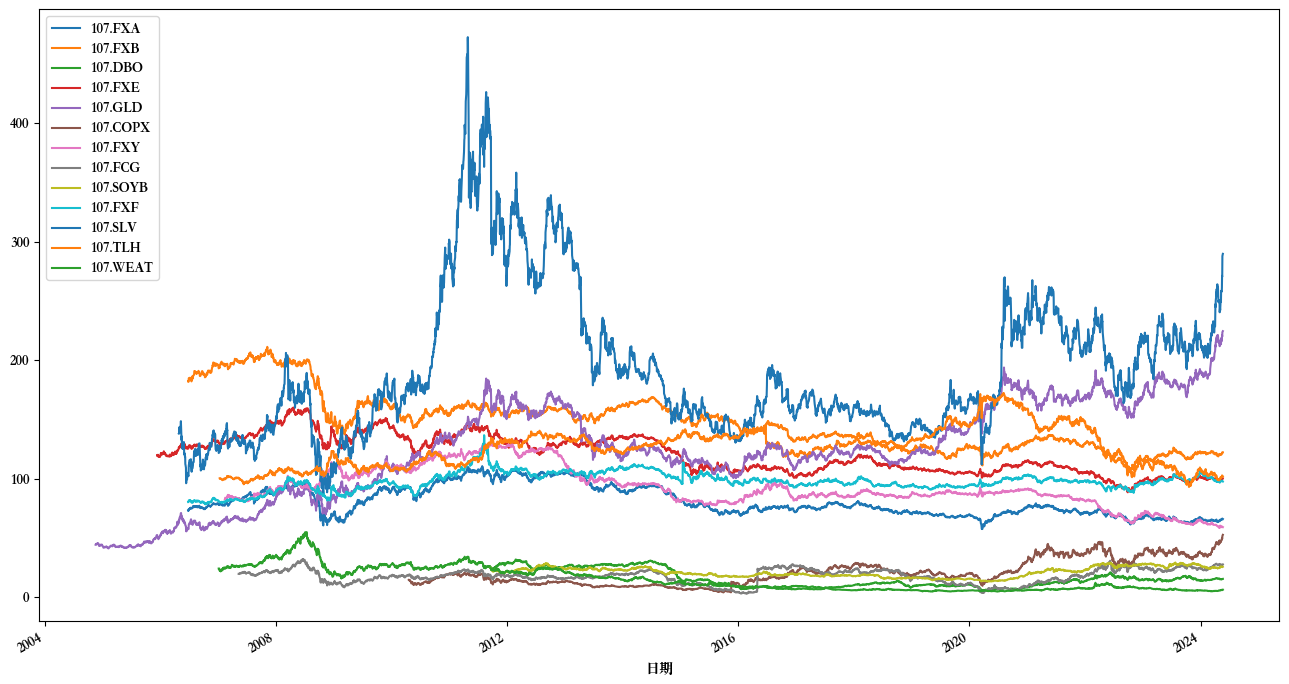

In [28]:
pd.DataFrame({code: data.loc[:, '收盘']
             for code, data in data_set.items()}).plot(figsize=(16, 9))

In [29]:
# 初始资金
INITIAL = 1000000
# 单个标的最大持仓
# LIMIT_CEIL = INITIAL * math.ceil(100 / math.sqrt(len(codes))) / 100
# LIMIT_FLOOR = INITIAL * math.floor(100 / math.sqrt(len(codes))) / 100
LIMIT_CEIL = INITIAL * 10 / 100
LIMIT_FLOOR = INITIAL * 9 / 100
print(f"初始资金：{INITIAL}，单个标的最大持仓：{LIMIT_CEIL}。")

初始资金：1000000，单个标的最大持仓：100000.0。


In [30]:
# 检验数据
for code, data in data_set.items():
    assert (data['收盘'] <= data['最高']).all(), (data['最高'] - data['收盘'])
    assert (data['最低'] <= data['收盘']).all(), (data['最低'] - data['收盘'])

In [31]:
# 选择 2013-01-01 到 2024-01-02 之间的数据
days = data_set['107.FXA']
days = days['2013-01-01' < days.index]
days = days[days.index <= '2024-01-02']
days = days.index

print(days[0])
print(days[-1])

years = 2024 - 2013

2013-01-02 00:00:00
2024-01-02 00:00:00


In [32]:
class ExtraCostTracker:
    '''
    模拟交易代理。
    参见 https://www.itigerup.com/help/detail/74820992
    '''
    extra: float = 0

    @staticmethod
    def clamp(value: float, floor: float, ceil: float) -> float:
        '''
        将 value 限制在 floor 和 ceil 之间。
        '''
        return max(floor, min(ceil, value))

    @staticmethod
    def p1(count: int, price: float) -> float:
        '''
        代理服务费用-交易佣金。
        '''
        return ExtraCostTracker.clamp(count * 0.0039, 0.99, count * price * 0.005)

    @staticmethod
    def p2(count: int, price: float) -> float:
        '''
        代理服务费用-平台费。
        '''
        return ExtraCostTracker.clamp(count * 0.004, 1, count * price * 0.005)

    @staticmethod
    def p3(count: int, price: float) -> float:
        '''
        代收费用-外部机构费及交易活动费。
        '''
        return ExtraCostTracker.clamp(count * 0.00396, 0.99, count * price * 0.01)

    @staticmethod
    def p4(count: int, price: float) -> float:
        '''
        代收费用-证监会费（仅卖单时收取）
        '''
        return max(count * price * 0.0000278, 0.01)

    def get(self):
        return self.extra

    def buy(self, count: int, price: float, ensure: bool) -> float:
        '''
        计算买入指定数量的标的所需的金额。
        '''
        p1 = self.p1(count, price)
        p2 = self.p2(count, price)
        p3 = self.p3(count, price)
        p = p1 + p2 + p3
        if ensure:
            self.extra += p
        return count * price + p

    def sell(self, count: int, price: float, ensure: bool) -> float:
        '''
        计算卖出指定数量的标的所得的金额。
        '''
        p1 = self.p1(count, price)
        p2 = self.p2(count, price)
        p3 = self.p3(count, price)
        p4 = self.p4(count, price)
        p = p1 + p2 + p3 + p4
        if ensure:
            self.extra += p
        assert count * price - p >= 0, f"count={count}, price={price}, p={p}"
        return count * price - p

In [33]:
class TradeTracker:
    '''
    交易跟踪器。
    记录当前正在进行的交易中已经投入的资金。
    '''
    @dataclass
    class WorkingTrade:
        '''
        正在进行的交易。
        '''
        start: datetime
        paid: float = 0
        earned: float = 0

    @dataclass
    class CompletedTrade:
        '''
        已完成的交易。
        '''
        code: str
        start: datetime
        end: datetime
        paid: float
        earned: float

    in_progress: dict[str, WorkingTrade]
    completed: list[CompletedTrade]

    def __init__(self):
        self.in_progress = {}
        self.completed = []

    def buy(self, code: str, money: float, today: datetime):
        '''
        买入指定标的。
        money: 包含了交易费用的成本。
        '''
        assert money > 0, f"money={money}"
        self.in_progress.setdefault(code, TradeTracker.WorkingTrade(today))
        self.in_progress[code].paid += money

    def sell(self, code: str, money: float, stock: int, today: datetime):
        '''
        卖出指定标的。
        money: 扣除了交易费用的收入。
        '''
        assert money > 0, f"money={money}"
        assert code in self.in_progress, f"code={code}"
        if stock > 0:
            trade = self.in_progress[code]
            trade.earned += money
        else:
            trade = self.in_progress.pop(code)
            self.completed.append(TradeTracker.CompletedTrade(
                code, trade.start, today, trade.paid, trade.earned + money))
        assert code in self.in_progress or stock == 0, f"code={code}"

In [34]:
class DetailRecorder:
    '''
    记录交易结果的指标。
    '''
    # 每日总资产
    daily_assets: dict[datetime, float]
    # 昨天的总资金
    yesterday_total: float
    # 至今为止的最大总资金
    max_total: float
    # 至今为止的最大总资金所在日期
    day_max_total: datetime

    # 最大（峰值）回撤率
    max_peak_drawdown: float
    # 最长（峰值）回撤长度
    longest_peak_drawdown: int
    # 最大（初始值）回撤率
    max_drawdown: float
    # （初始值）回撤长度
    drawdown_length: int
    # 最长（初始值）回撤长度
    longest_drawdown: int

    def __init__(self):
        self.daily_assets = {}
        self.yesterday_total = INITIAL
        self.max_total = INITIAL
        self.day_max_total = days[0]
        self.longest_peak_drawdown = 0
        self.drawdown_length = 0
        self.longest_drawdown = 0
        self.max_drawdown = 0
        self.max_peak_drawdown = 0

    def record(self, today: datetime, total: float):
        '''
        记录交易结果。
        '''
        self.daily_assets.setdefault(today, total)
        if total > self.max_total:
            self.max_total = total
            self.longest_peak_drawdown = max(
                self.longest_peak_drawdown, (today - self.day_max_total).days)
            self.day_max_total = today
        if total < INITIAL:
            self.drawdown_length += 1
            self.longest_drawdown = max(
                self.longest_drawdown, self.drawdown_length)
        else:
            self.drawdown_length = 0
        self.max_peak_drawdown = max(
            self.max_peak_drawdown, (self.max_total - total) / self.max_total)
        self.max_drawdown = max(self.max_drawdown, (INITIAL - total) / INITIAL)
        self.yesterday_total = total

In [35]:
@dataclass(init=False)
class Detail:
    '''
    交易结果的指标。
    CAGR：年均回报率。
    MAR：年均回报率与最大（峰值）回撤率之比。
    Sharpe：夏普比率。
    Trades：交易次数。
    W：交易胜率。
    MaxPeakDrawdown：最大（峰值）回撤率。
    LongestPeakDrawdown：最大（峰值）回撤长度。
    MaxDrawdown：最大（初始值）回撤率。
    LongestDrawdown：最大（初始值）回撤长度。
    '''
    CAGR: float
    MAR: float
    Sharpe: float
    Trades: int
    W: float
    MaxPeakDrawdown: float
    LongestPeakDrawdown: int
    MaxDrawdown: float
    LongestDrawdown: int

    def __init__(self, recorder: DetailRecorder, tracker: TradeTracker):
        y = [*recorder.daily_assets.values()]
        self.CAGR = (y[-1] / y[0]) ** (1 / years) - 1
        self.MAR = self.CAGR / recorder.max_peak_drawdown
        returns = (pd.DataFrame.from_dict(
            recorder.daily_assets, orient='index') - INITIAL) / INITIAL
        self.Sharpe = self.CAGR / returns.std().iloc[0]
        self.Trades = len(tracker.completed)
        self.W = sum(1 for t in tracker.completed if t.earned >
                     t.paid) / self.Trades if self.Trades > 0 else np.nan
        trades = pd.DataFrame(
            [(t.earned - t.paid) / t.paid for t in tracker.completed]
        )
        trades.columns = ['单次交易收益率']

        edges = np.histogram_bin_edges(trades, bins='auto')
        trades.hist(bins=len(edges), figsize=(16, 9))
        self.MaxPeakDrawdown = recorder.max_peak_drawdown
        self.LongestPeakDrawdown = recorder.longest_peak_drawdown
        self.MaxDrawdown = recorder.max_drawdown
        self.LongestDrawdown = recorder.longest_drawdown

    def to_dict(self):
        return {
            'CAGR%': self.CAGR*100,
            'MAR': self.MAR,
            'Sharpe': self.Sharpe,
            'Trades': self.Trades,
            'W%': self.W*100,
            'Max DD': self.MaxPeakDrawdown,
            'DD Length': self.LongestPeakDrawdown,
            'Max DD (Since Beginning)': self.MaxDrawdown,
            'DD Length (Since Beginning)': self.LongestDrawdown,
        }

In [36]:
class Strategy:
    '''
    交易策略。
    '''

    def __init__(self):
        self.agent = ExtraCostTracker()
        self.tracker = TradeTracker()
        self.cash = INITIAL
        self.stocks: dict[str, int] = {code: 0 for code in data_set.keys()}
        self.recorder = DetailRecorder()
        self.result: dict[datetime, dict] = {}
        self.detail = DetailRecorder()

    def buy_at_most(self, code: str, money: float, yesterday: datetime, today: datetime):
        '''
        买入指定标的。
        '''
        # 买入
        close_yesterday: float = data.loc[yesterday, '收盘']
        open_today: float = data.loc[today, '开盘']
        if self.stocks[code] * close_yesterday < LIMIT_CEIL:
            # 不能超过最大持仓量向下取整的值，同时要考虑具体策略
            to_buy = min(
                (LIMIT_FLOOR - self.stocks[code] * close_yesterday),
                money,
                self.cash
            ) // open_today
            assert to_buy % 1 == 0
            to_buy = int(to_buy)
            while to_buy > 0 and self.agent.sell(to_buy, open_today, False) > self.cash:
                to_buy -= 1
            if to_buy > 0:
                money = self.agent.sell(to_buy, open_today, True)
                self.cash -= money
                self.stocks[code] += to_buy
                self.tracker.buy(code, money, today)
        assert self.cash >= 0

    def sell_all(self, code: str, today: datetime):
        '''
        卖出指定标的。
        '''
        # 卖出
        if self.stocks[code] > 0:
            open_today: float = data.loc[today, '开盘']
            money = self.agent.sell(
                self.stocks[code], open_today, True)
            self.cash += money
            self.stocks[code] = 0
            self.tracker.sell(code, money, 0, today)
        assert self.cash >= 0

    def sell_at_least(self, code: str, money: float, today: datetime):
        # 卖出
        # 卖出后的持仓量不能超过最大持仓量向下取整的值
        open_today: float = data.loc[today, '开盘']
        to_sell = min(math.ceil(money / open_today), self.stocks[code])
        assert to_sell % 1 == 0
        to_sell = int(to_sell)
        # assert to_sell >= 0, (to_sell, stocks[code], cash)
        if to_sell > 0:
            money = self.agent.sell(to_sell, open_today, True)
            self.cash += money
            self.stocks[code] -= to_sell
            self.tracker.sell(code, money, self.stocks[code], today)
        assert self.cash >= 0

    def sell_to_limit(self, code: str, today: datetime):
        open_today: float = data.loc[today, '开盘']
        self.sell_at_least(code, self.stocks[code] * open_today -
                           LIMIT_FLOOR, today)

    @abstractmethod
    def preprocess(self):
        '''
        预处理。
        '''
        raise NotImplementedError

    @abstractmethod
    def one_day(self, code: str, days: tuple[datetime, datetime, datetime], data: pd.DataFrame):
        '''
        运行策略。
        前天、昨天、今天。
        '''
        raise NotImplementedError

    def run(self) -> Detail:
        '''
        运行策略。
        '''
        self.preprocess()

        for i in range(len(days)):
            total = 0
            today: datetime = days[i]

            # 找到上一个交易日的日期
            yesterday: datetime = today - timedelta(1)
            while yesterday not in data_set['107.FXA'].index:
                yesterday -= timedelta(1)
            day_before_yesterday: datetime = yesterday - timedelta(1)
            while day_before_yesterday not in data_set['107.FXA'].index:
                day_before_yesterday -= timedelta(1)

            for code in self.tracker.in_progress:
                assert self.stocks[code] > 0, (code, self.stocks[code])

            for code, data in data_set.items():
                assert day_before_yesterday < yesterday < today
                self.one_day(
                    code, (day_before_yesterday, yesterday, today), data)
                close_today: float = data.loc[today, '收盘']
                total += close_today * self.stocks[code]
            total += self.cash

            for code in self.tracker.in_progress:
                assert self.stocks[code] > 0, (code, self.stocks[code])

            last_month = today - timedelta(30)
            while last_month not in days:
                last_month += timedelta(1)
            last_month_total = self.result[last_month]['资金'] if last_month in self.result else total

            last_year = today - timedelta(365)
            while last_year not in days:
                last_year += timedelta(1)
            last_year_total = self.result[last_year]['资金'] if last_year in self.result else total

            self.detail.record(today, total)
            r = {
                '日期': today,
                '现金': self.cash,
                '资金': total,
                '累计额外费用': self.agent.get(),
                '初始值回撤': self.detail.max_drawdown,
                '峰值回撤': self.detail.max_peak_drawdown,
                '累计回报率': (total - INITIAL) / INITIAL,
                '月度回报率': (total - last_month_total) / last_month_total,
                '年度回报率': (total - last_year_total) / last_year_total,
            }

            r.update({
                f'{code}-stock': self.stocks[code] for code, _ in data_set.items()
            })
            r.update({
                f'{code}-value': data.loc[today, '收盘'] * self.stocks[code] for code, data in data_set.items()
            })
            self.result.setdefault(today, r)

        df = pd.DataFrame(self.result.values())
        df.plot(y=['现金', '资金'], x='日期', figsize=(16, 9))
        df.plot(y=['累计额外费用'], x='日期', figsize=(16, 9))
        df.plot(y=['峰值回撤', '初始值回撤', '累计回报率', '月度回报率',
                   '年度回报率'], x='日期', figsize=(16, 9))
        df.plot(y=[f'{code}-stock' for code in data_set.keys()],
                x='日期', figsize=(20, 10))
        df.plot(y=[f'{code}-value' for code in data_set.keys()],
                x='日期', figsize=(20, 10))
        print(df.iloc[-1].loc[['现金', '资金', '累计额外费用', '累计回报率']])
        df.loc[:, ['现金', '资金', '累计额外费用', '初始值回撤', '峰值回撤', '累计回报率', '月度回报率', '年度回报率']].describe(percentiles=[
            0.05, 0.25, 0.5, 0.75, 0.95])
        return Detail(self.detail, self.tracker)

#### ATR 通道突破系统


In [37]:
class ATRChannelBreakout(Strategy):
    '''
    ATR通道突破策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['通道顶部'] = data['350日移动平均收盘价'] + 7 * data['平均真实波幅']
            data['通道底部'] = data['350日移动平均收盘价'] - 3 * data['平均真实波幅']

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        close_: float = data.loc[day_before_yesterday, '收盘']
        upper_: float = data.loc[day_before_yesterday, '通道顶部']

        close: float = data.loc[yesterday, '收盘']
        upper: float = data.loc[yesterday, '通道顶部']
        lower: float = data.loc[yesterday, '通道底部']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if close * stock > LIMIT_CEIL:
            self.sell_to_limit(code, today)
        elif close > upper:
            self.buy_at_most(code, int((close - upper) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif close < lower:
            self.sell_all(code, today)

#### 布林通道突破系统


In [38]:
class BollingerChannelBreakout(Strategy):
    '''
    布林通道突破策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['通道顶部'] = data['350日移动平均收盘价'] + 2.5 * data['平均真实波幅']
            data['通道底部'] = data['350日移动平均收盘价'] - 2.5 * data['平均真实波幅']

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        close_: float = data.loc[day_before_yesterday, '收盘']
        upper_: float = data.loc[day_before_yesterday, '通道顶部']

        close: float = data.loc[yesterday, '收盘']
        upper: float = data.loc[yesterday, '通道顶部']
        lower: float = data.loc[yesterday, '通道底部']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if close * self.stocks[code] > LIMIT_CEIL:
            self.sell_to_limit(code, today)
        elif close > upper:
            self.buy_at_most(code, int((close - upper) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif close < lower:
            self.sell_all(code, today)

#### 唐奇安趋势系统


In [39]:
class DonchianTrend(Strategy):
    '''
    唐奇安趋势策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['25日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(25)).mean()

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        short_: float = data.loc[day_before_yesterday, '收盘']
        long_: float = data.loc[day_before_yesterday, '通道顶部']

        close: float = data.loc[yesterday, '收盘']
        long: float = data.loc[yesterday, '350日移动平均收盘价']
        short: float = data.loc[yesterday, '25日移动平均收盘价']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if close * self.stocks[code] > LIMIT_CEIL:
            self.sell_to_limit(code, today)
        elif code in self.tracker.in_progress and self.tracker.in_progress[code].paid / self.stocks[code] - close > 2 * atr:
            # 两倍 ATR 的止损退出点（相对于现在持有的 ETF 的平均成本）
            assert self.stocks[code] > 0
            # print(f"退出：{code}，{close}，{self.stocks[code]}")
            self.sell_all(code, today)
        elif short > long:
            self.buy_at_most(code, int((short - long) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif short < long:
            self.sell_all(code, today)
            # self.sell_at_least(code, int((long - short) / atr) * 0.01 *
            #                    self.detail.yesterday_total - close * stock, today)

#### 定时退出唐奇安趋势系统


In [40]:
class DonchianTrendWithTimeExit(Strategy):
    '''
    定时退出唐奇安趋势策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['25日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(25)).mean()

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        short_: float = data.loc[day_before_yesterday, '收盘']
        long_: float = data.loc[day_before_yesterday, '通道顶部']

        close: float = data.loc[yesterday, '收盘']
        long: float = data.loc[yesterday, '350日移动平均收盘价']
        short: float = data.loc[yesterday, '25日移动平均收盘价']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if code in self.tracker.in_progress and self.tracker.in_progress[code].start + timedelta(80) <= today:
            # 80 天后退出
            assert self.stocks[code] > 0
            self.sell_all(code, today)
        elif close * self.stocks[code] > LIMIT_CEIL:
            self.sell_to_limit(code, today)
        elif short > long:
            self.buy_at_most(code, int((short - long) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif short < long:
            self.sell_all(code, today)
            # self.sell_at_least(code, int((long - short) / atr) * 0.01 *
            #                    self.detail.yesterday_total - close * stock, today)

#### 双重移动平均线系统


In [41]:
class DualMovingAverage(Strategy):
    '''
    双重移动平均线策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['100日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(100)).mean()

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        short_: float = data.loc[day_before_yesterday, '收盘']
        long_: float = data.loc[day_before_yesterday, '通道顶部']

        close: float = data.loc[yesterday, '收盘']
        long: float = data.loc[yesterday, '350日移动平均收盘价']
        short: float = data.loc[yesterday, '100日移动平均收盘价']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if short > long:
            self.buy_at_most(code, int((short - long) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif short < long:
            self.sell_all(code, today)

#### 三重移动平均线系统


In [42]:
class TripleMovingAverage(Strategy):
    '''
    三重移动平均线策略。
    '''

    def preprocess(self):
        for code, data in data_set.items():
            data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
            data['平均真实波幅'] = data['真实波幅'].rolling(14).mean()
            data['350日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(350)).mean()
            data['250日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(250)).mean()
            data['150日移动平均收盘价'] = data['收盘'].rolling(
                timedelta(150)).mean()

    def one_day(self, code: str, days, data: pd.DataFrame):
        day_before_yesterday, yesterday, today = days

        medium_: float = data.loc[day_before_yesterday, '250日移动平均收盘价']
        short_: float = data.loc[day_before_yesterday, '150日移动平均收盘价']

        close: float = data.loc[yesterday, '收盘']
        long: float = data.loc[yesterday, '350日移动平均收盘价']
        medium: float = data.loc[yesterday, '250日移动平均收盘价']
        short: float = data.loc[yesterday, '150日移动平均收盘价']
        atr: float = data.loc[yesterday, '平均真实波幅']
        stock = self.stocks[code]

        if short > medium > long:
            self.buy_at_most(code, int((short - medium) / atr) * 0.01 *
                             self.detail.yesterday_total - close * stock, yesterday, today)
        elif short < medium < long:
            self.sell_all(code, today)

## 实验结果与分析

### 单个交易系统的结果


In [43]:
comparison: dict[str, Detail] = {}

现金         589607.505537
资金        3395503.475537
累计额外费用       2902.455913
累计回报率           2.395503
Name: 2767, dtype: object


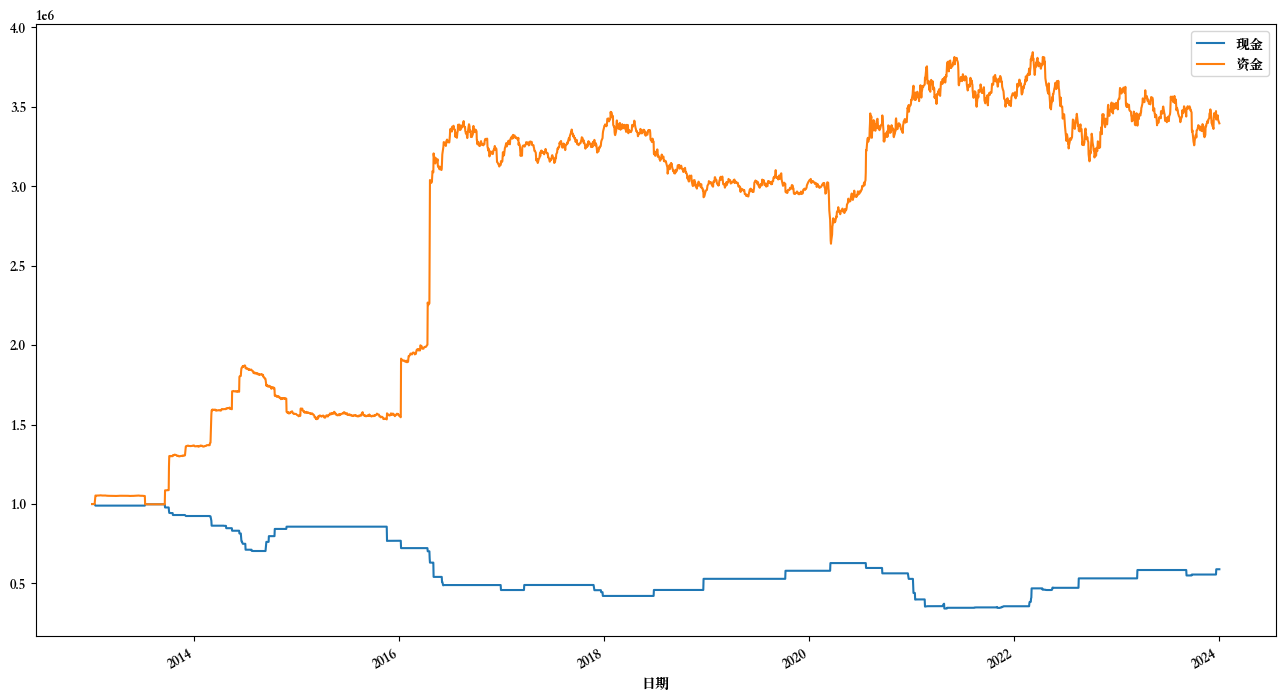

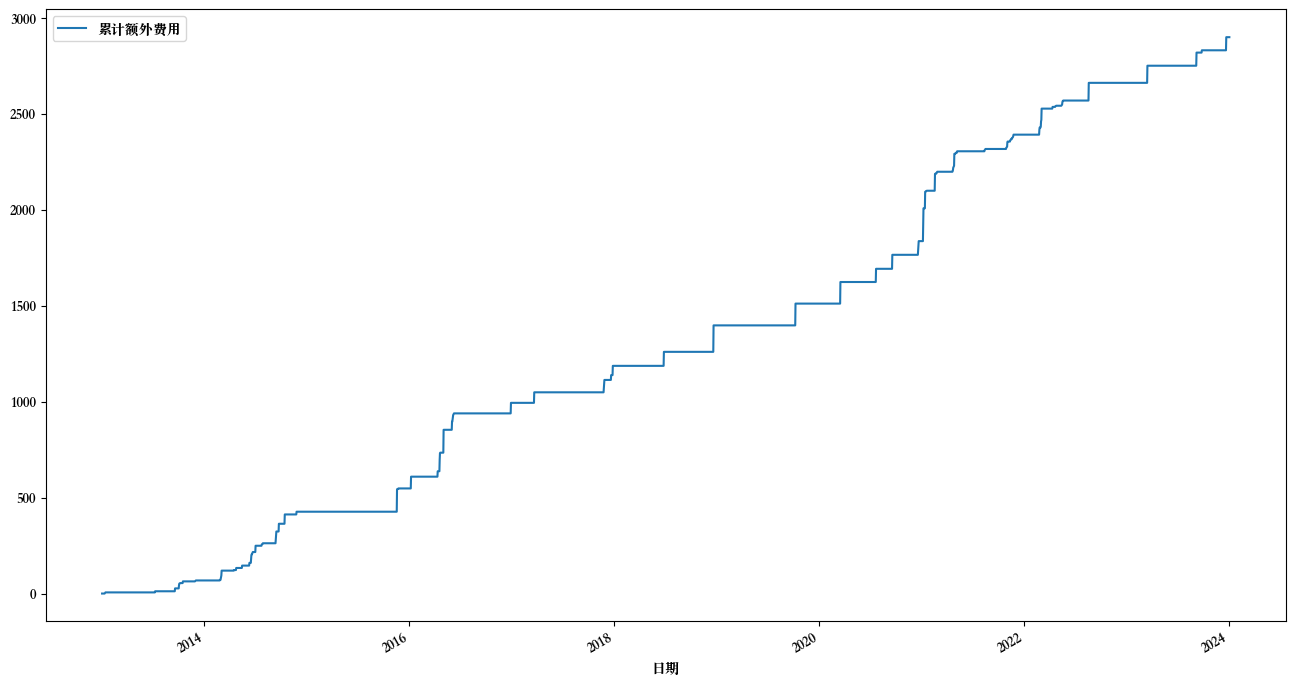

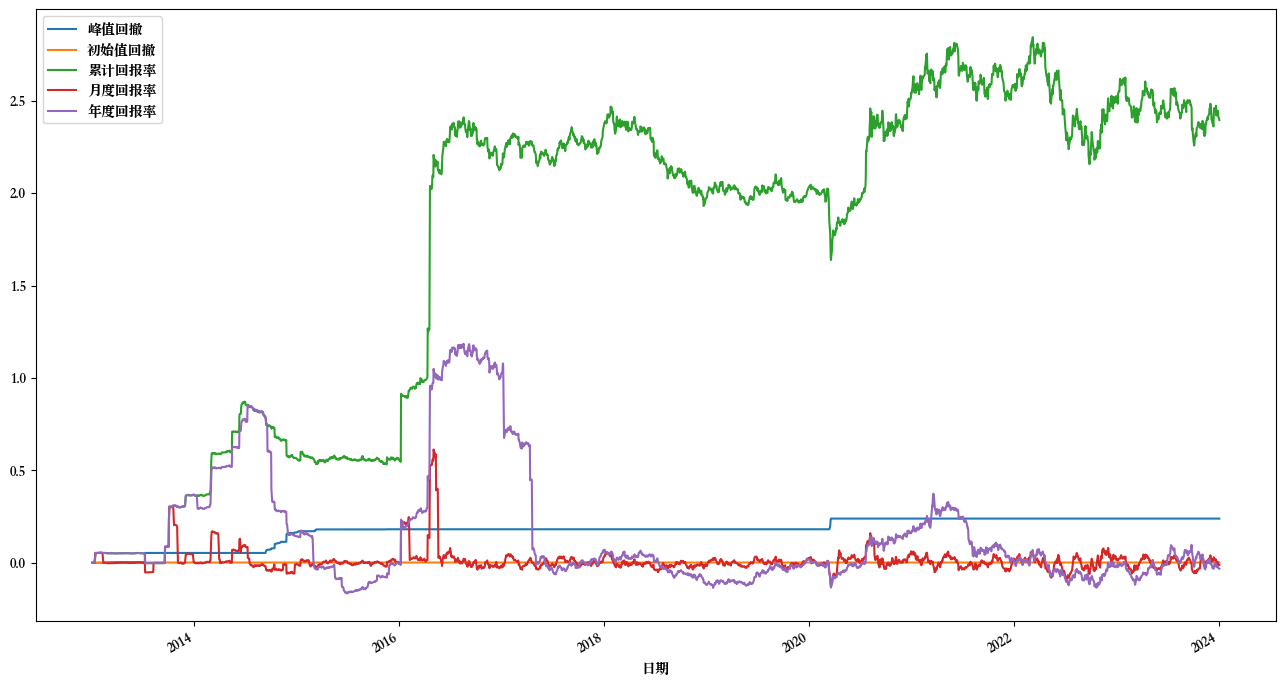

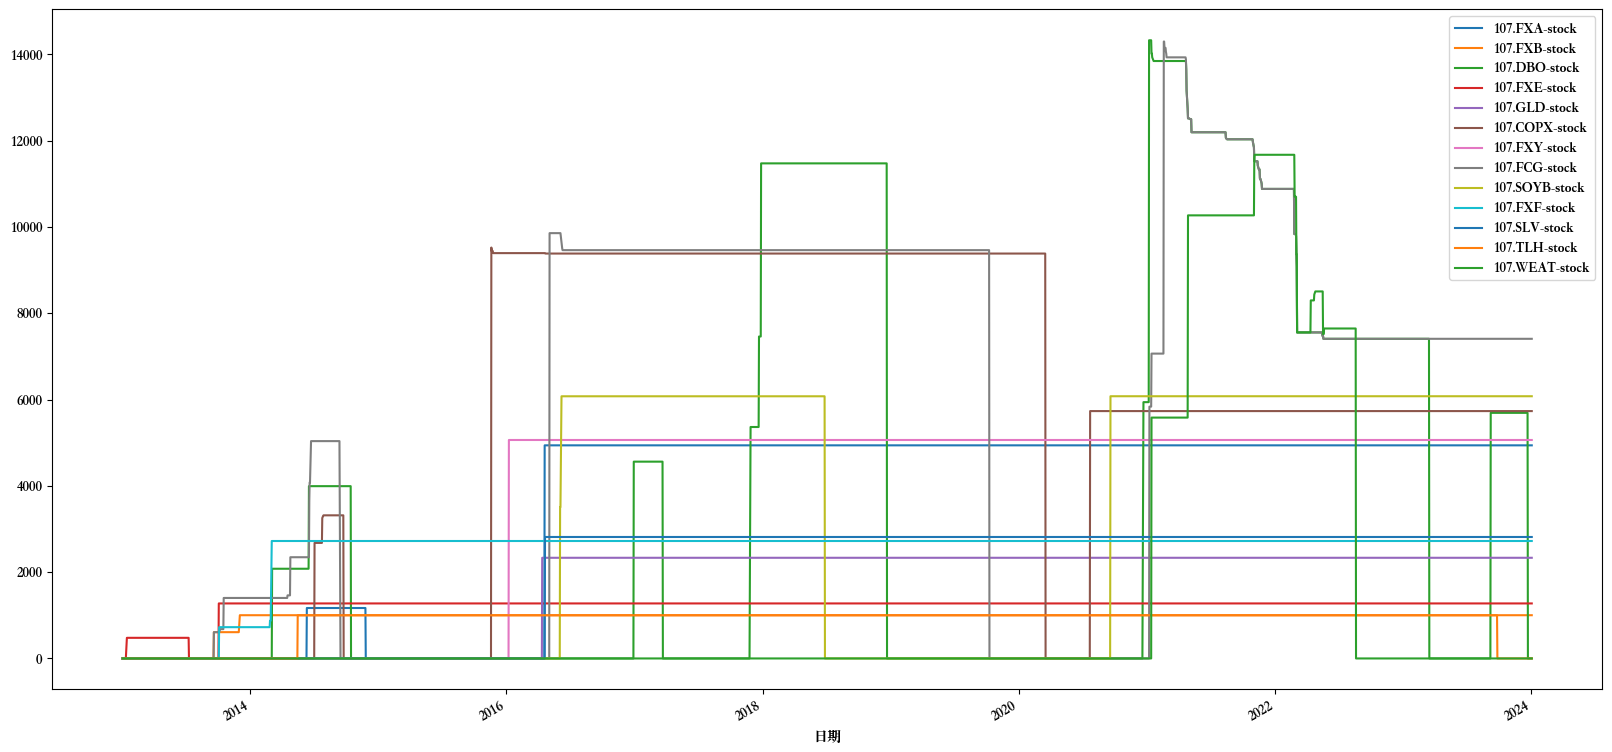

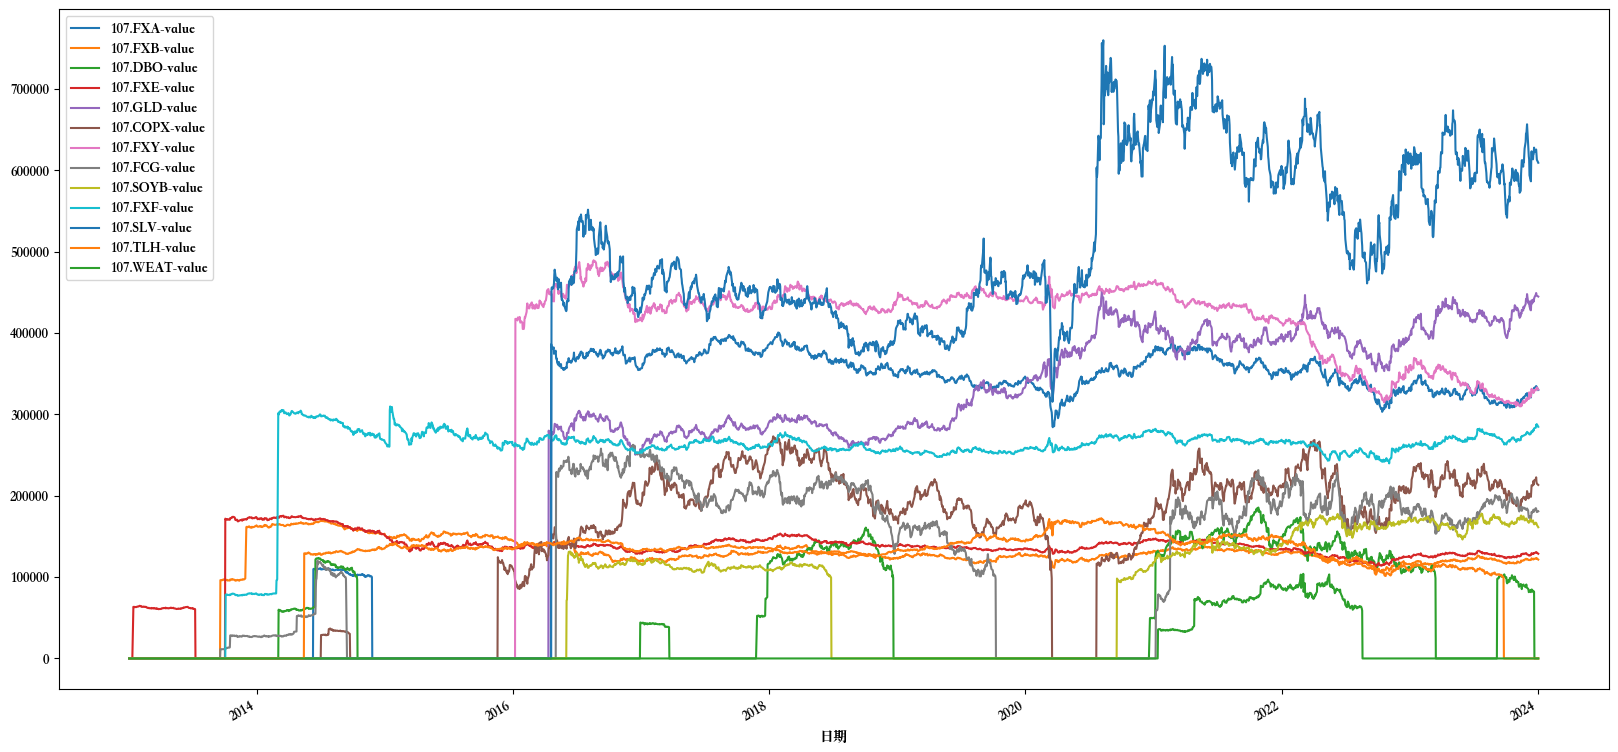

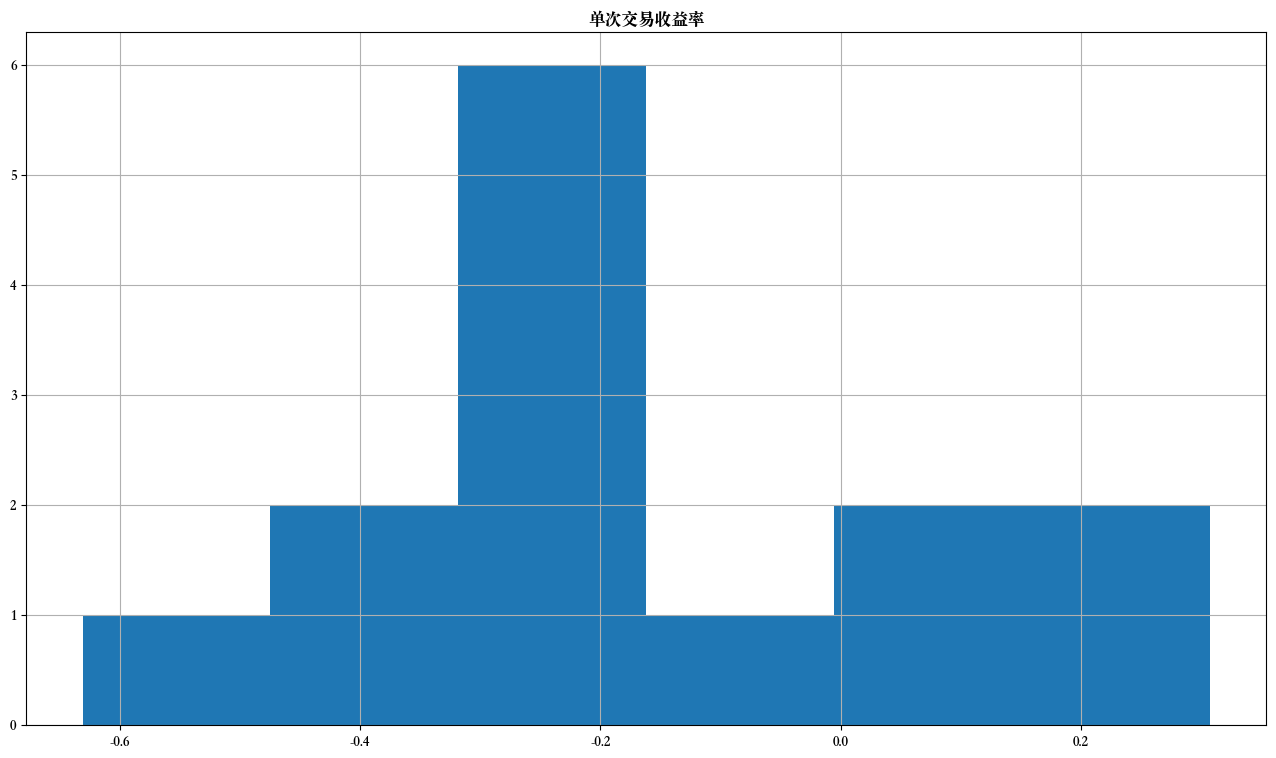

In [44]:
atr_cb = ATRChannelBreakout().run()
comparison['ATR通道突破策略'] = atr_cb

现金         574404.375734
资金        2704476.275734
累计额外费用       4867.547358
累计回报率           1.704476
Name: 2767, dtype: object


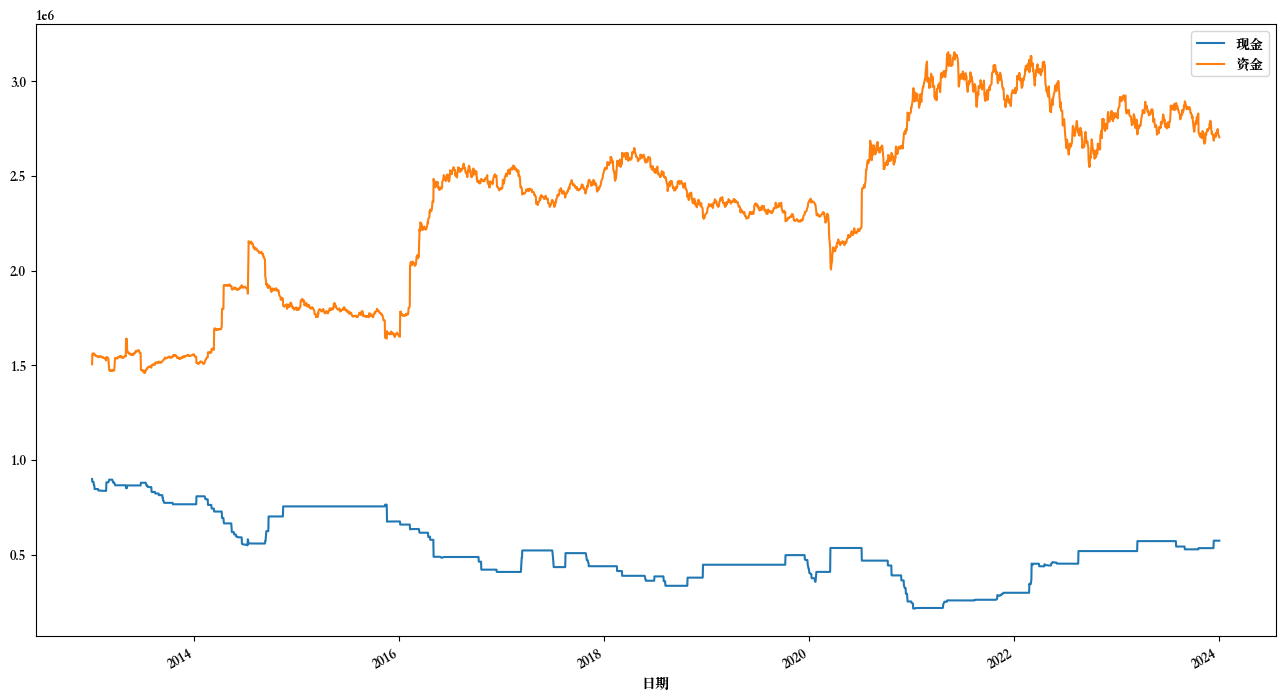

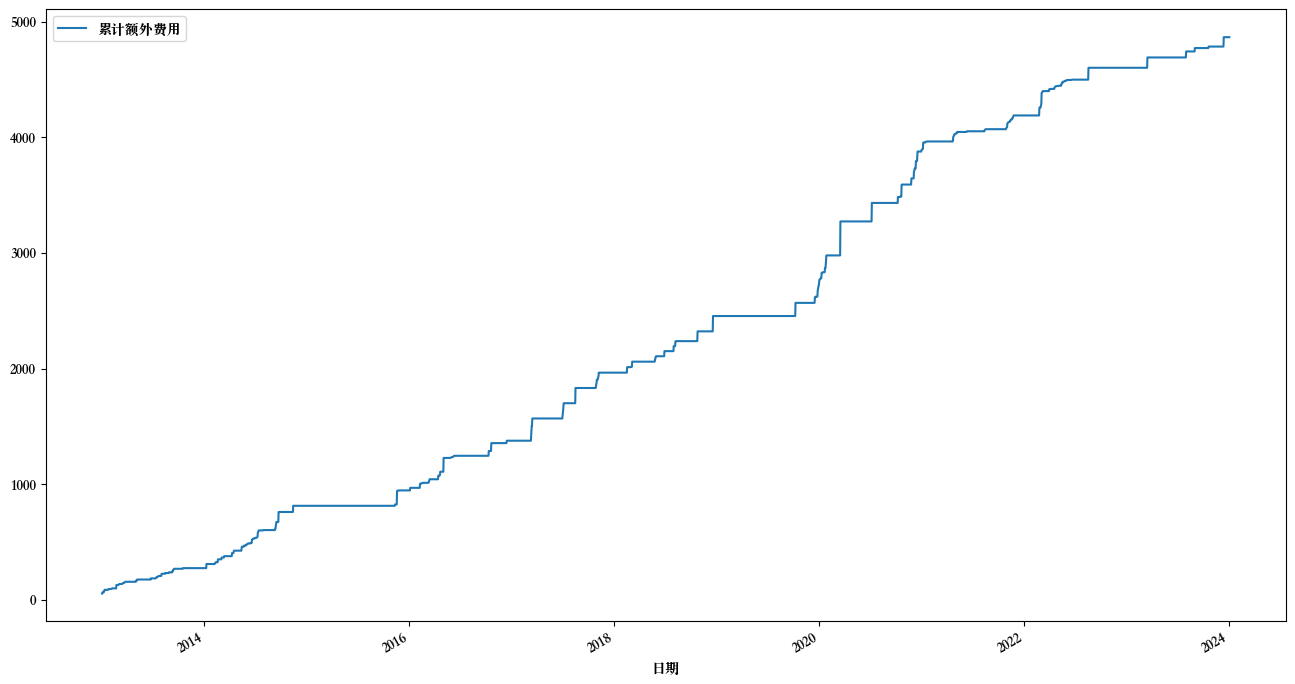

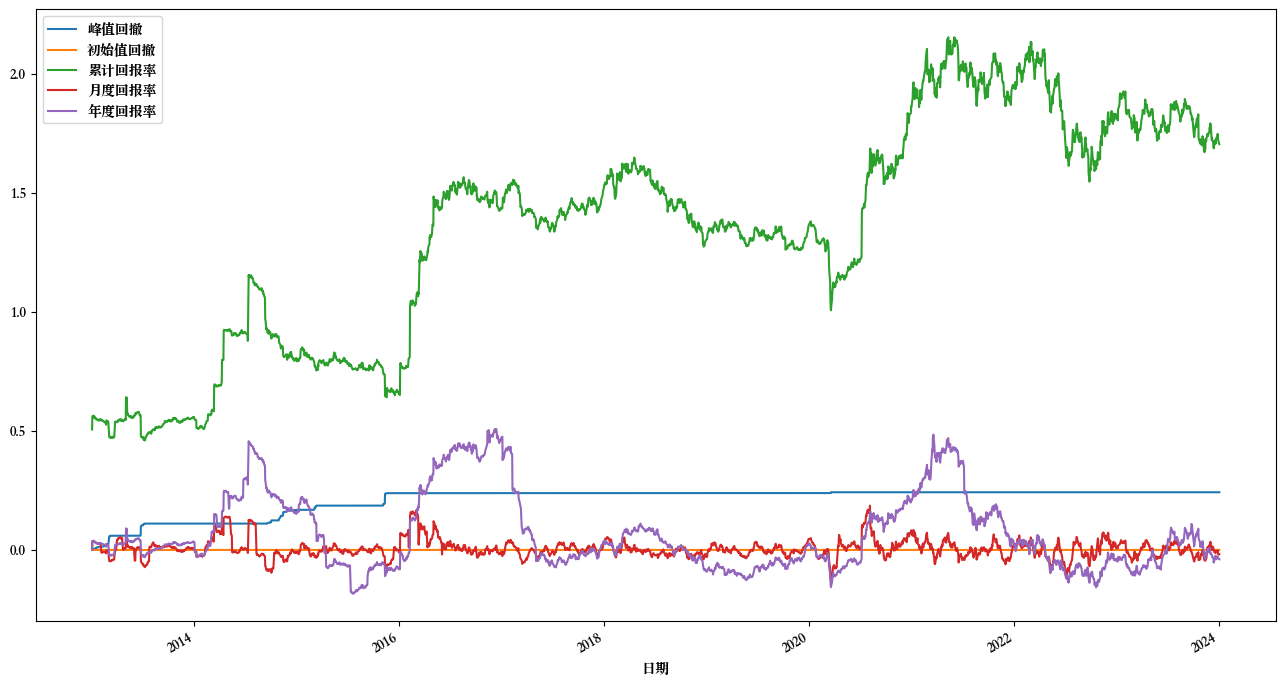

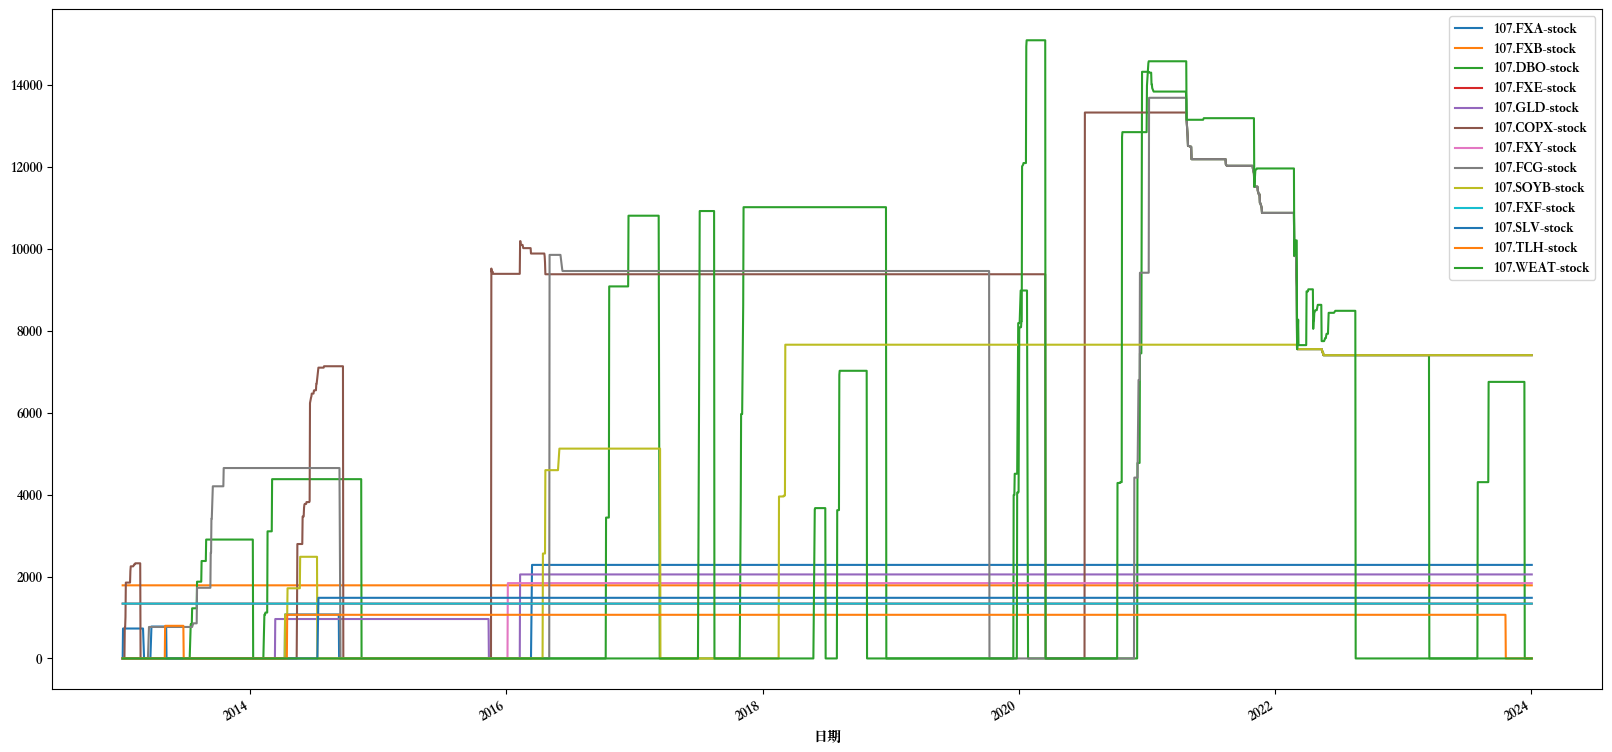

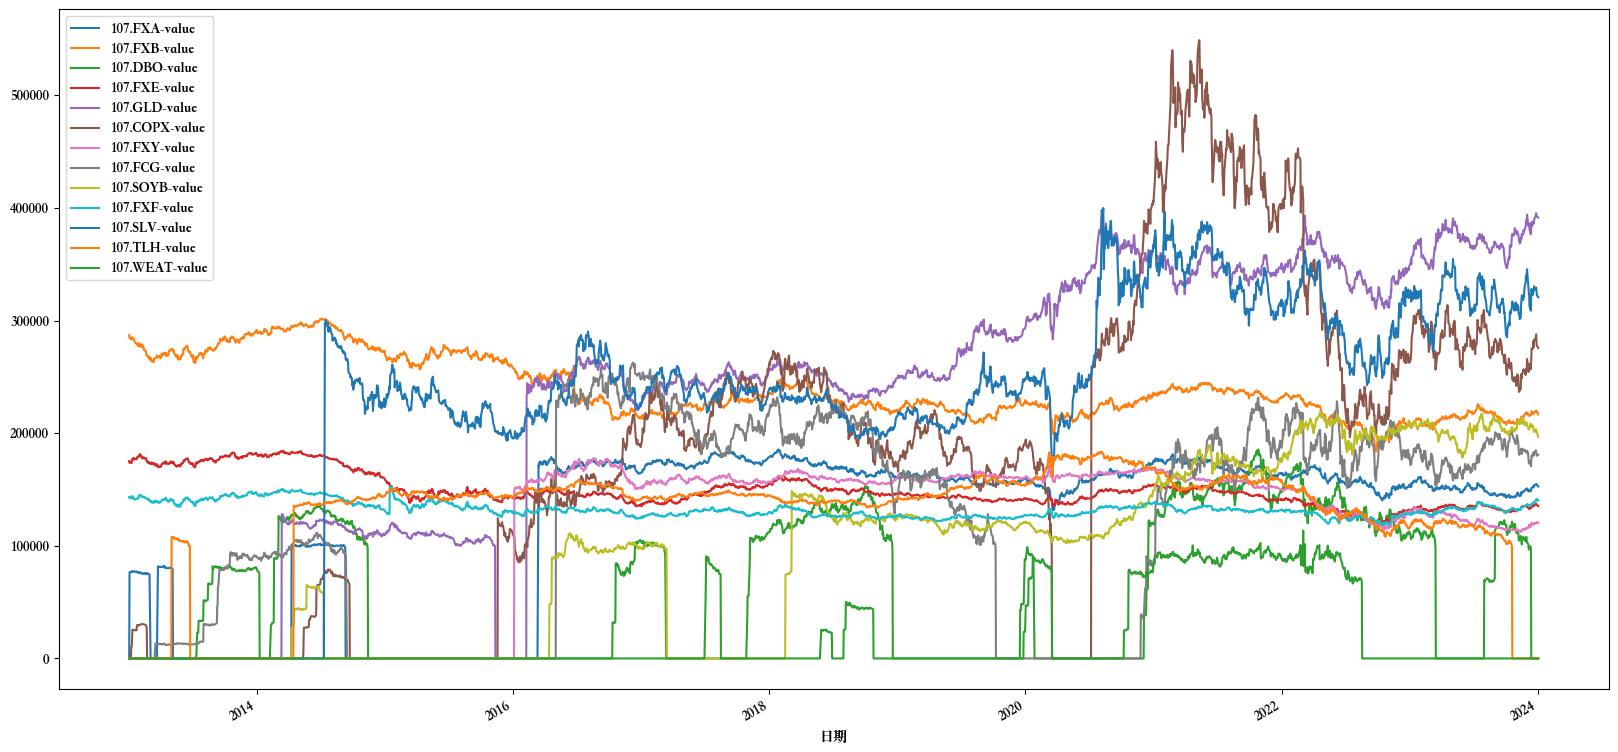

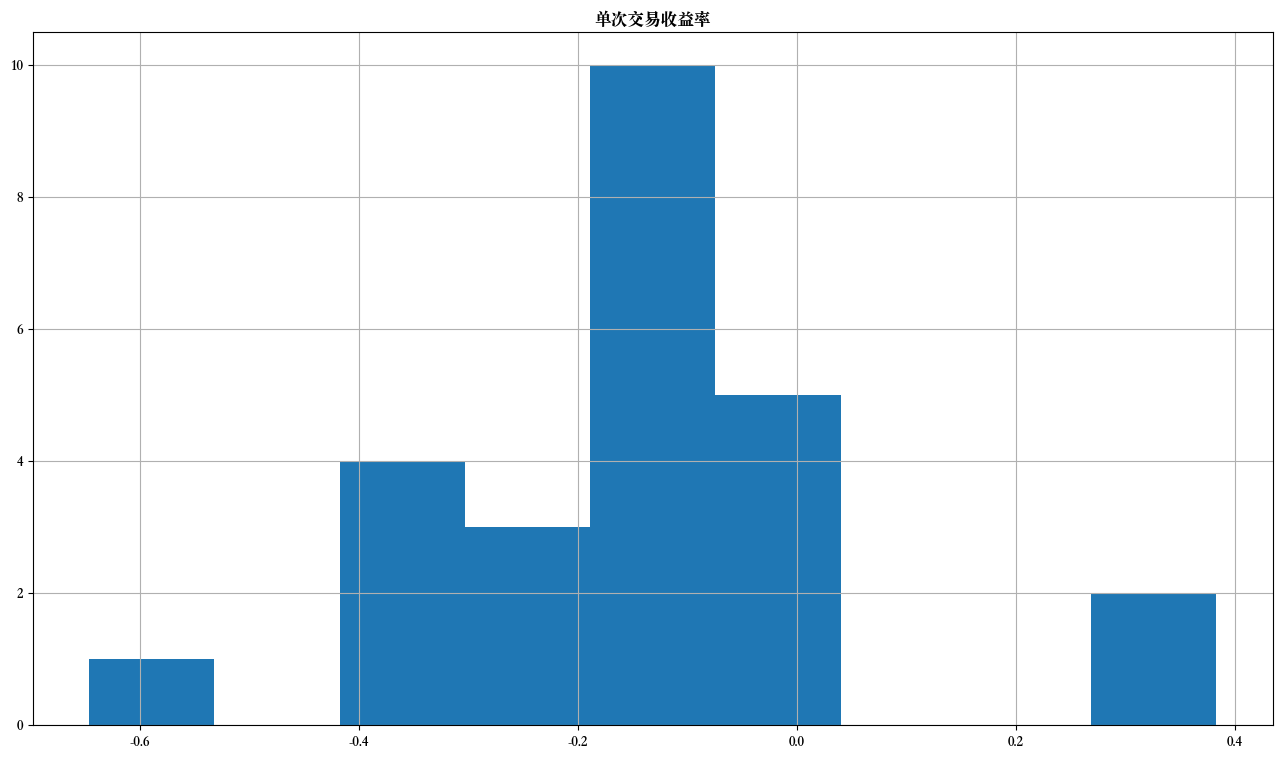

In [45]:
bollinger_cb = BollingerChannelBreakout().run()
comparison['布林通道突破策略'] = bollinger_cb

现金         473536.344954
资金        3150488.734954
累计额外费用      18891.580383
累计回报率           2.150489
Name: 2767, dtype: object


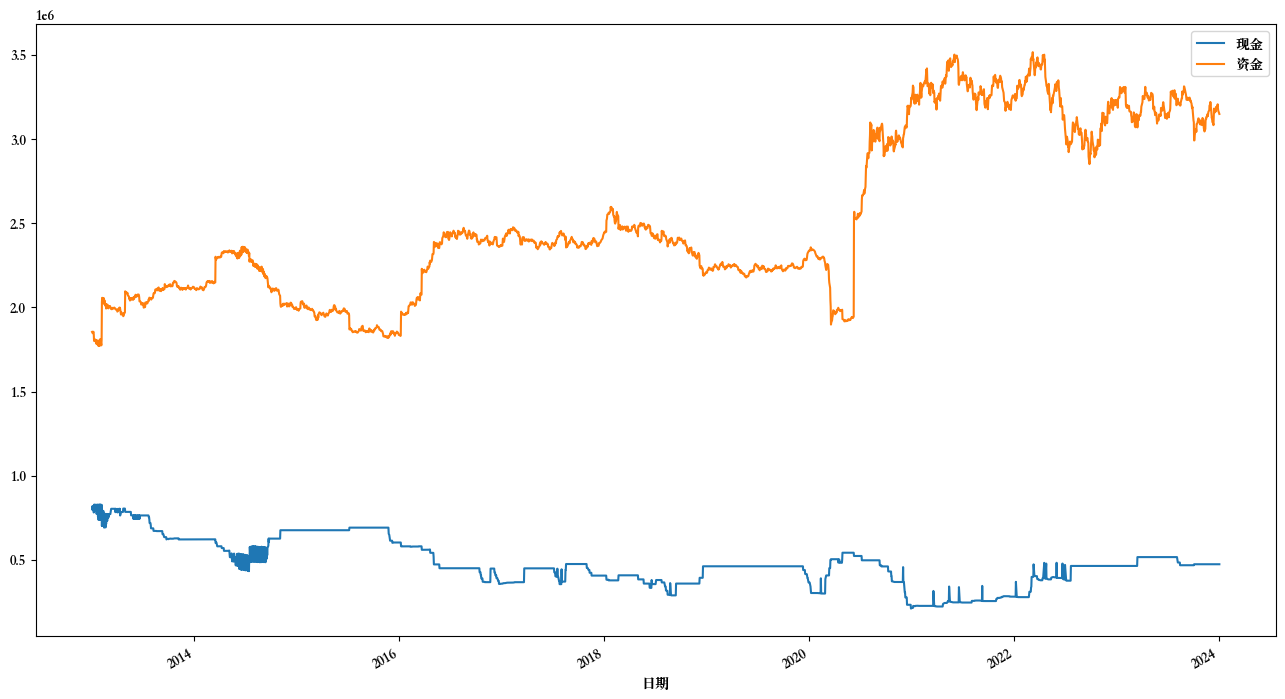

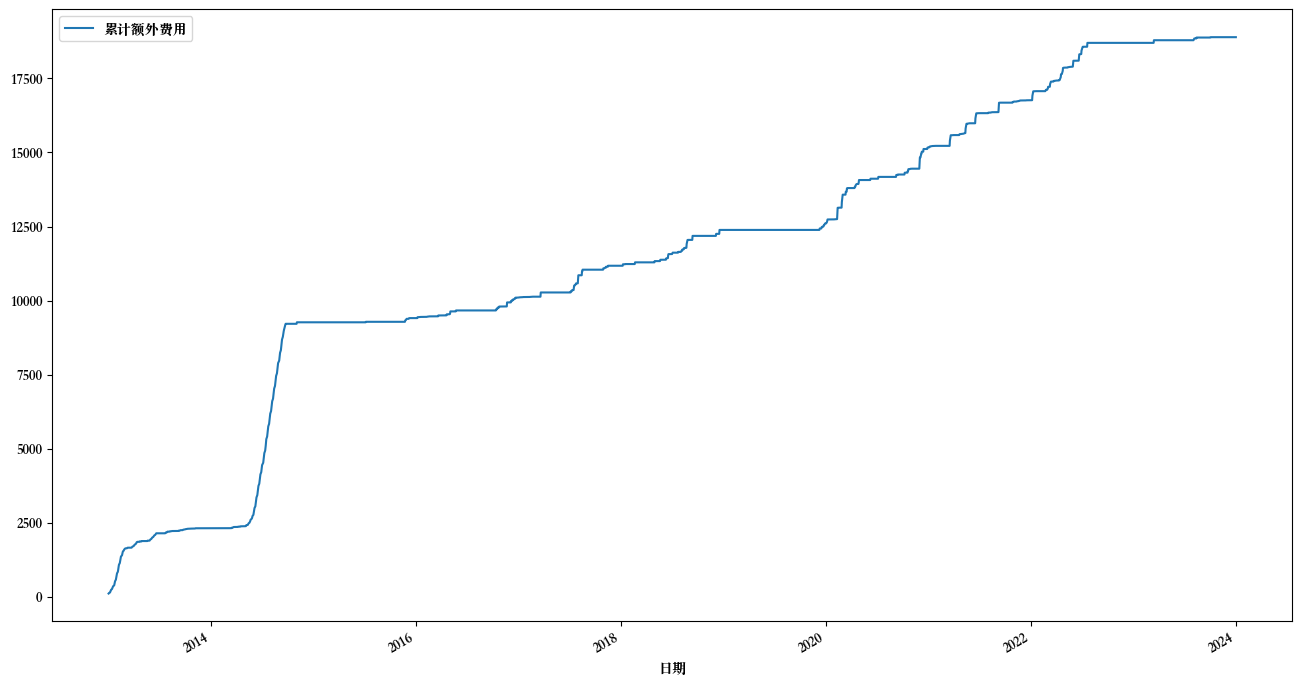

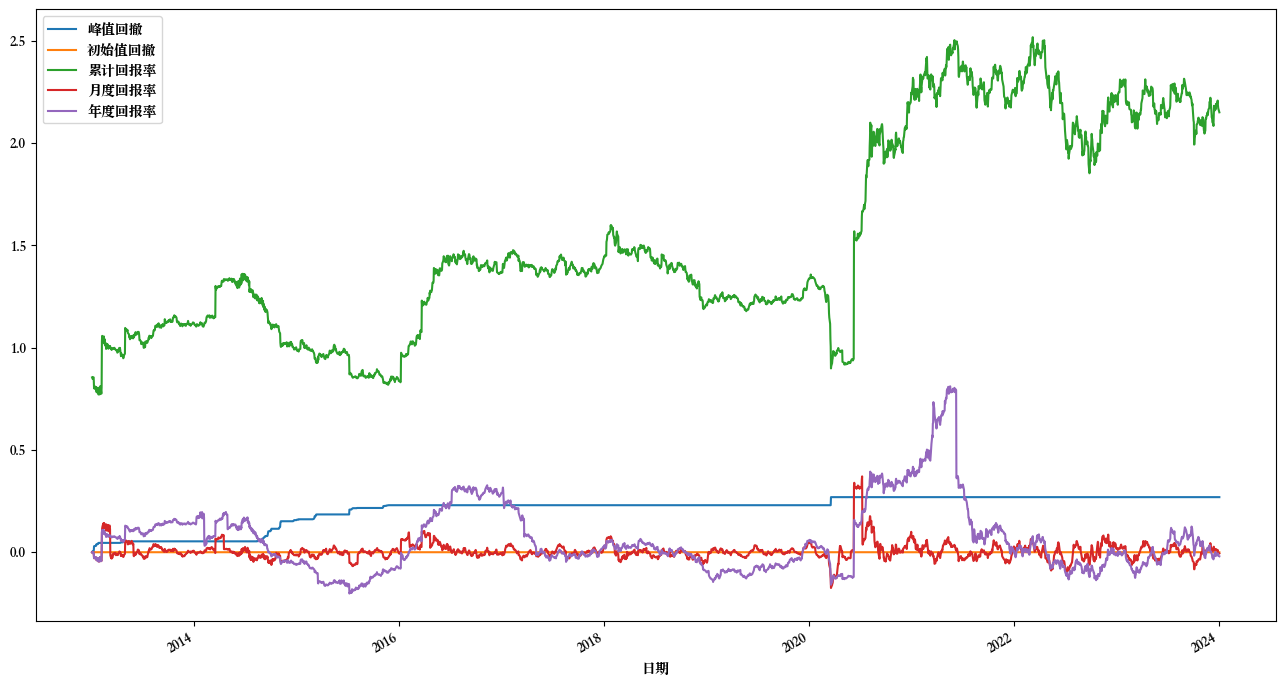

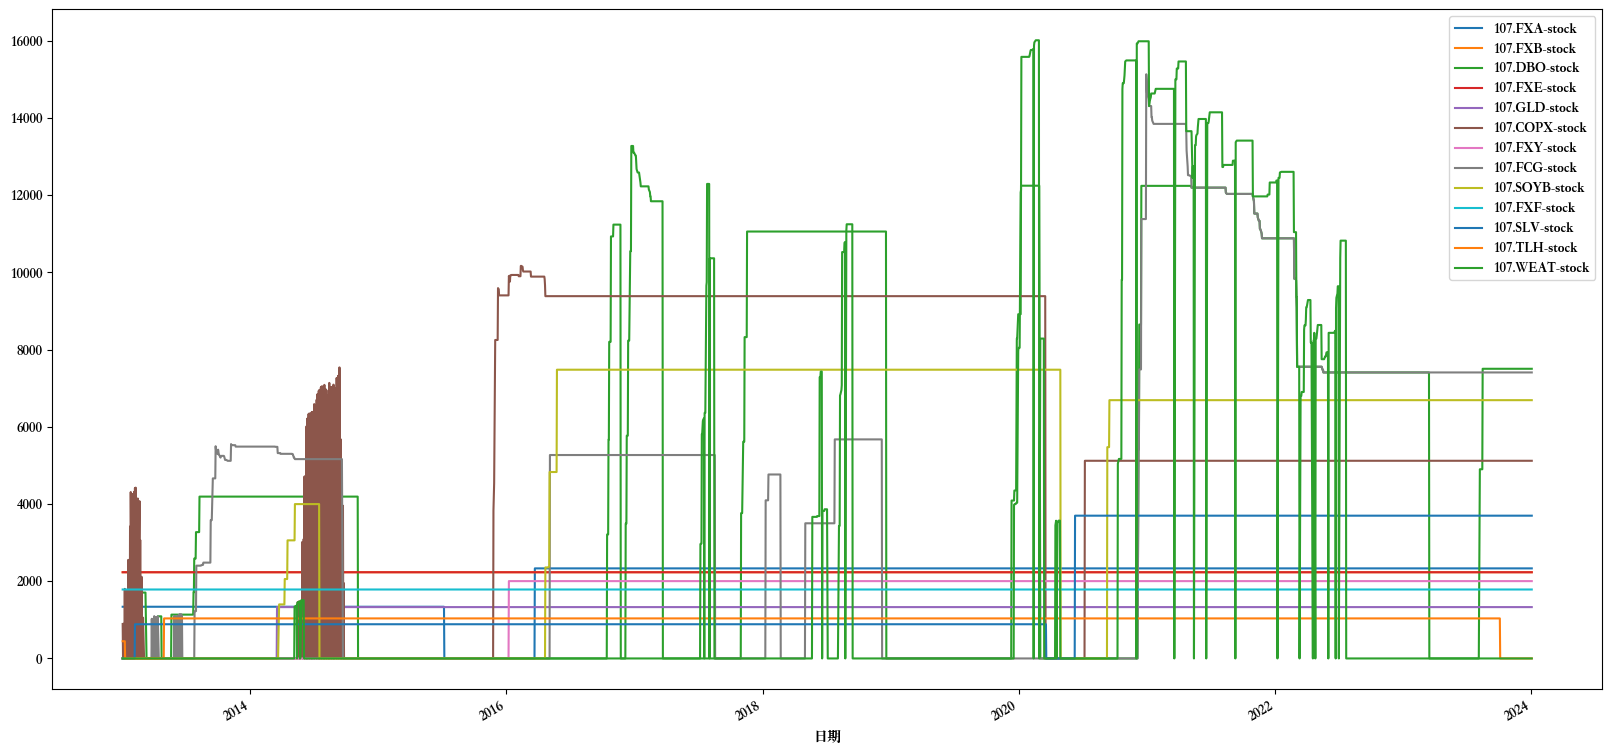

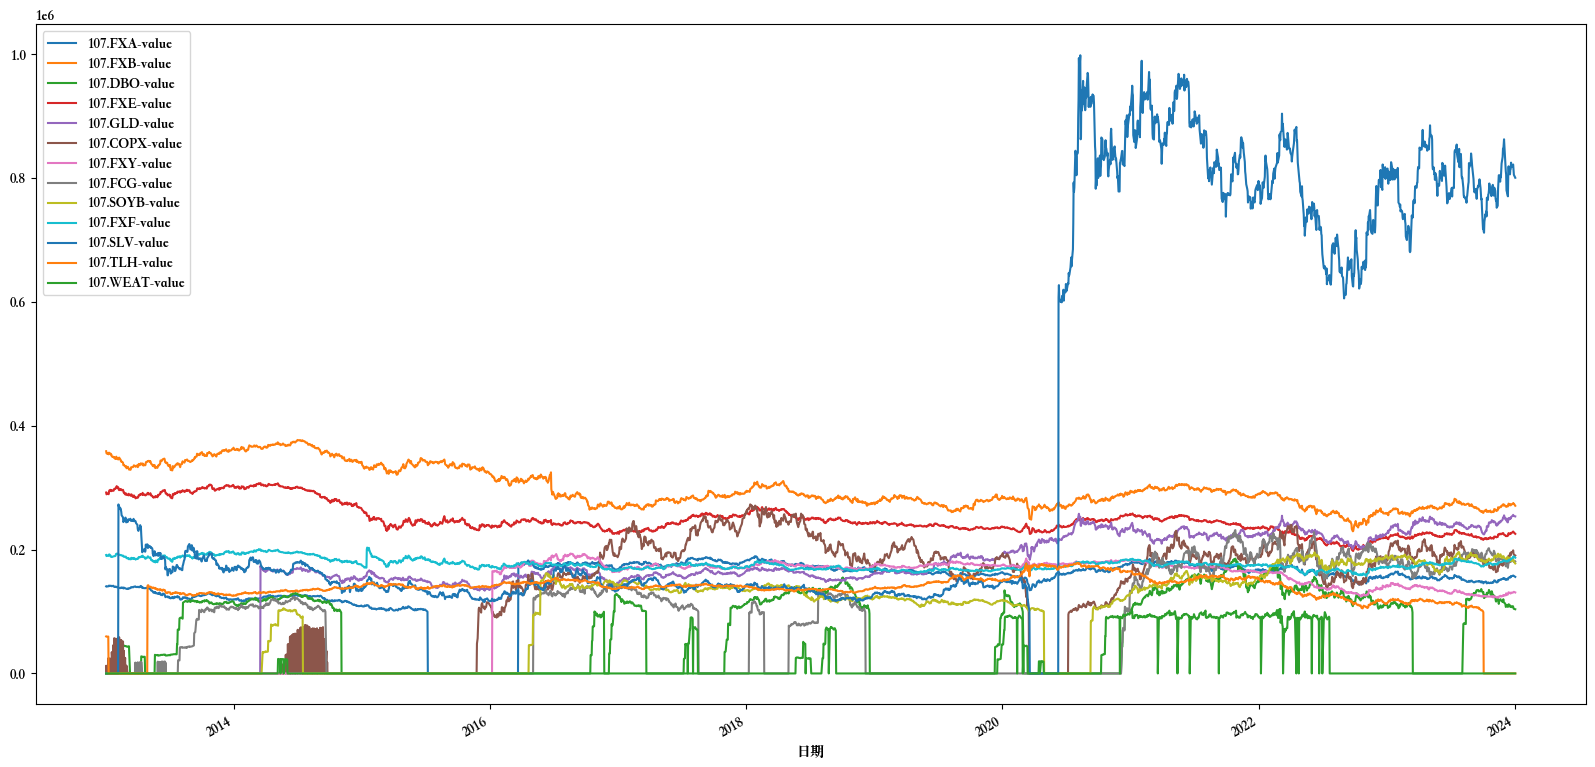

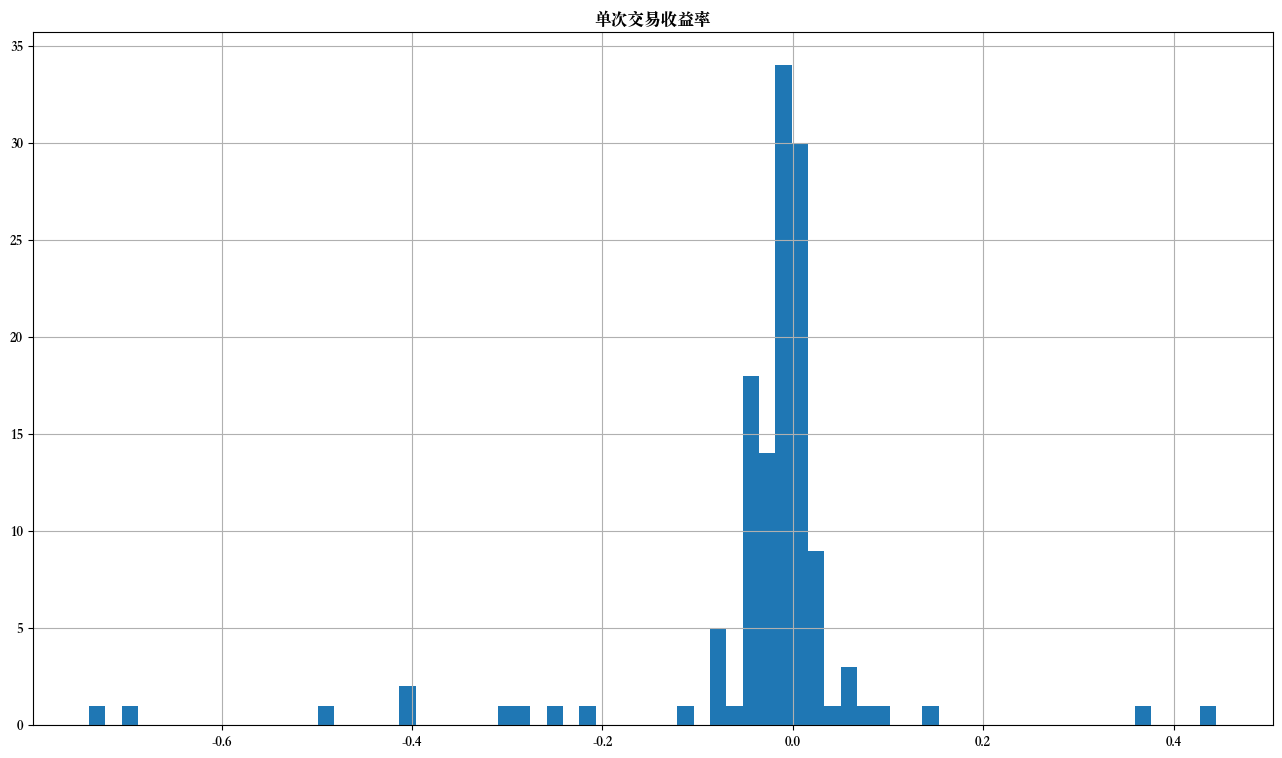

In [46]:
donchain_trend = DonchianTrend().run()
comparison['唐奇安趋势策略'] = donchain_trend

现金              25.907495
资金        10484568.997495
累计额外费用       61707.542253
累计回报率            9.484569
Name: 2767, dtype: object


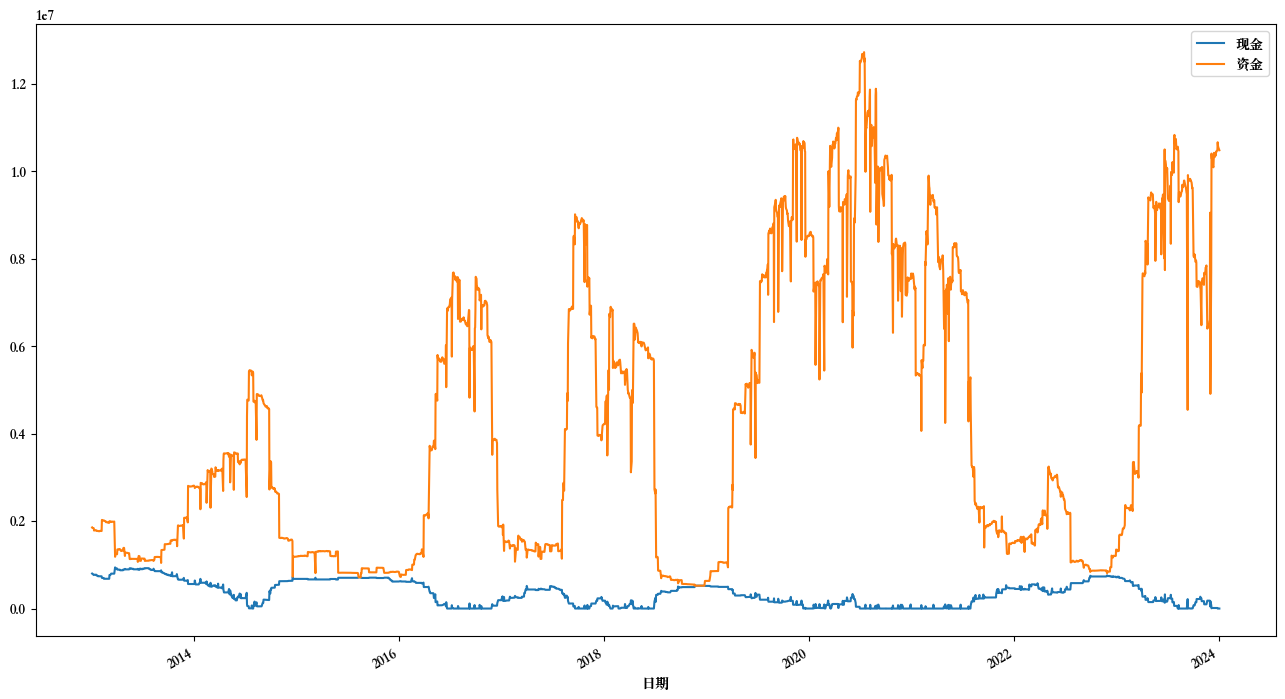

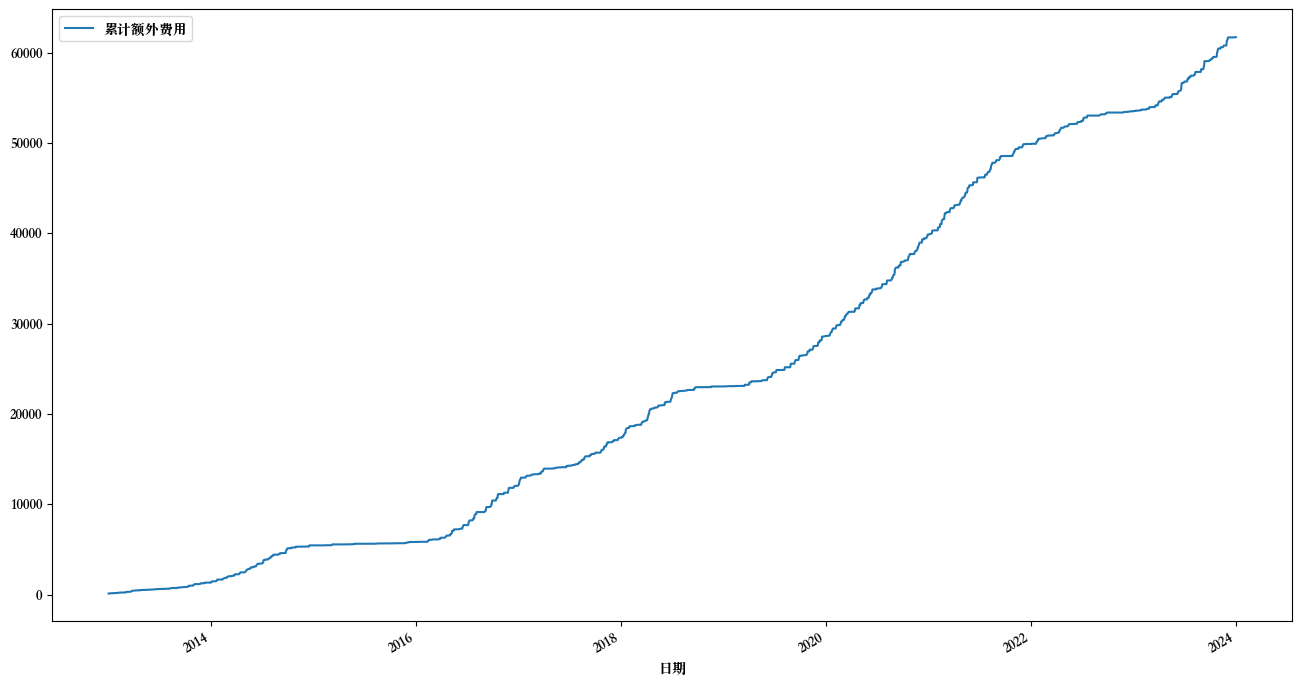

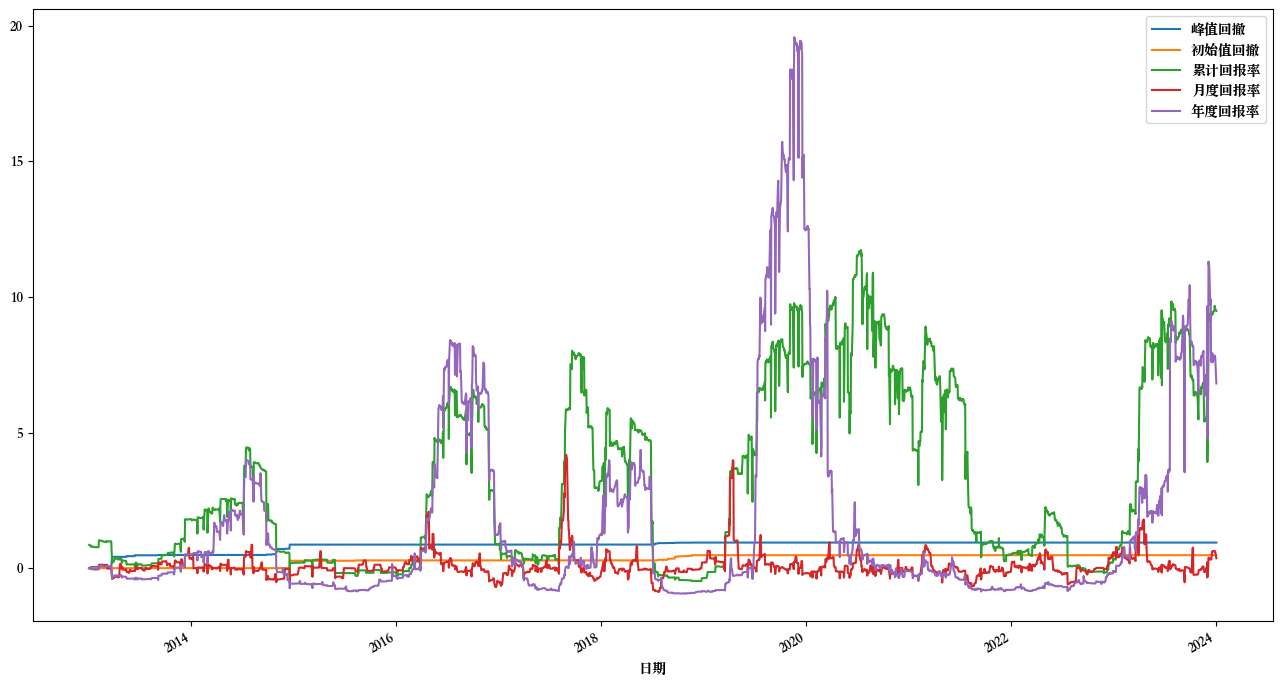

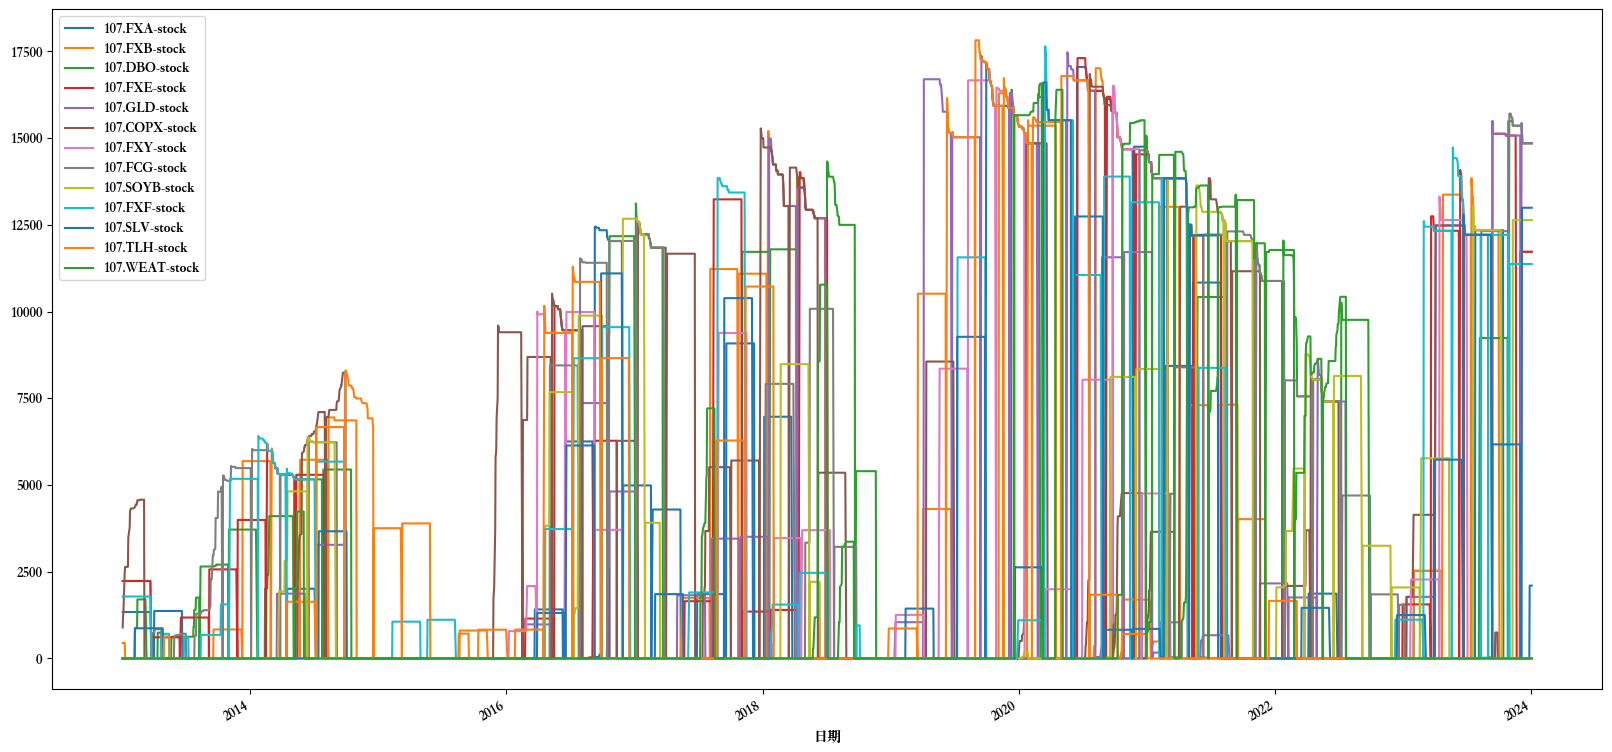

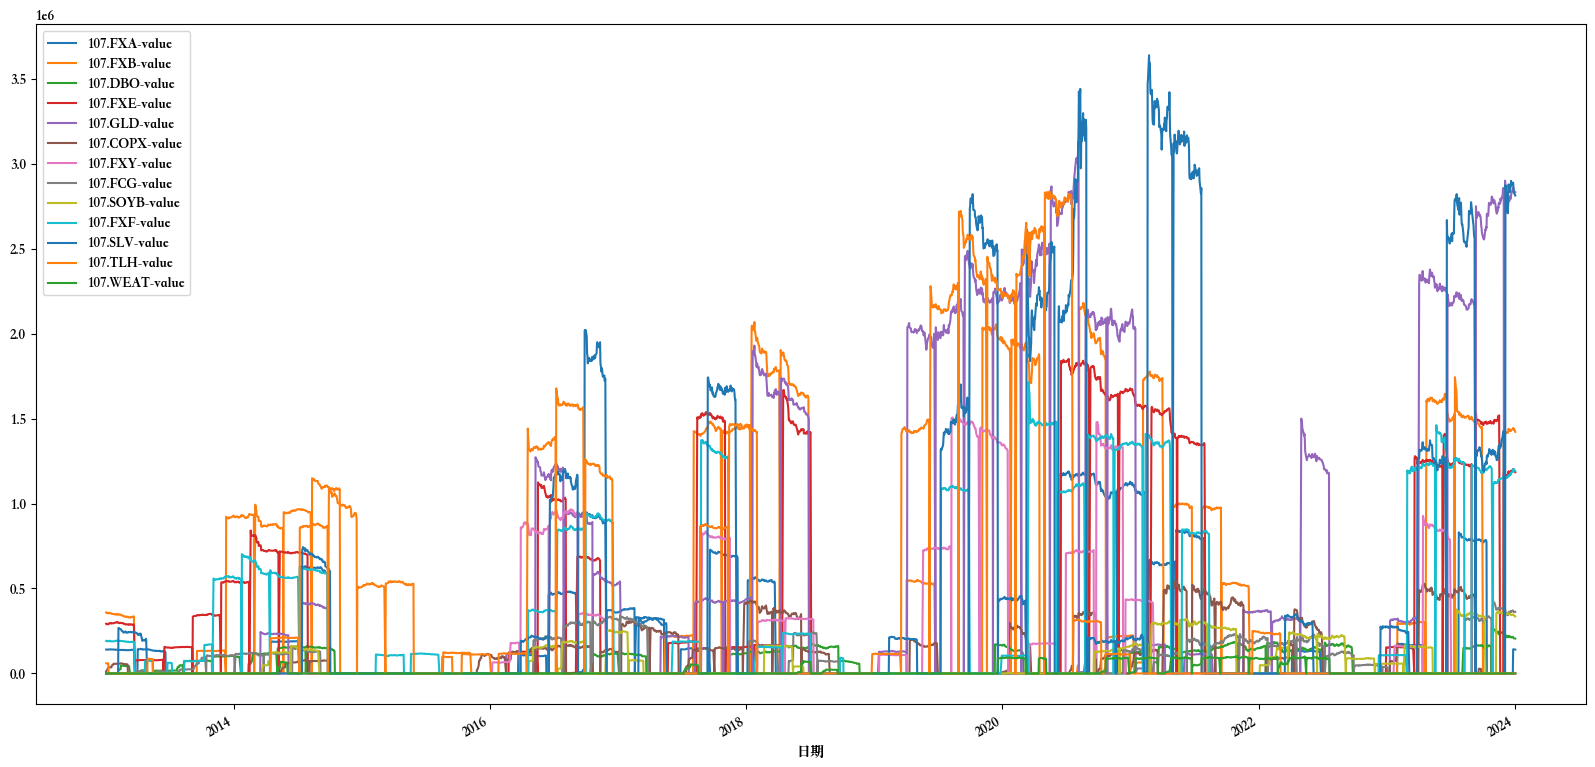

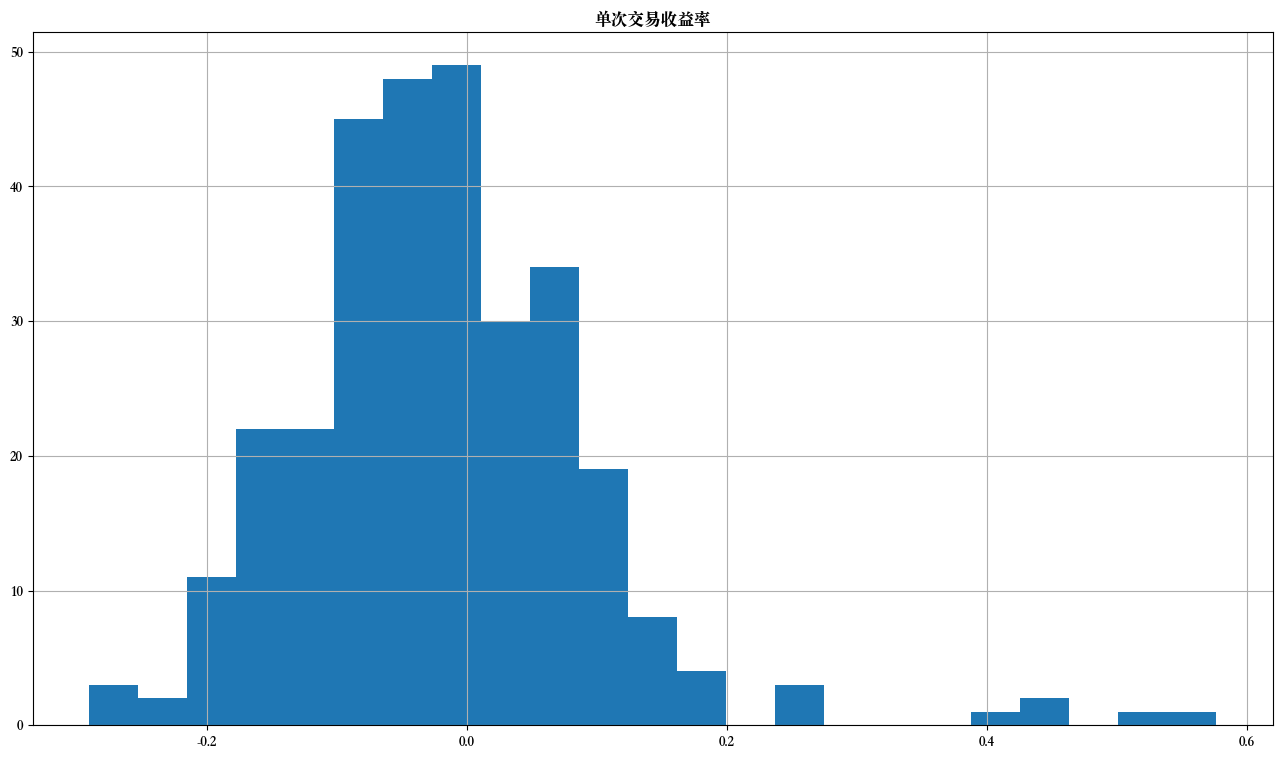

In [47]:
donchain_trend_te = DonchianTrendWithTimeExit().run()
comparison['定时退出唐奇安趋势策略'] = donchain_trend_te

现金         629418.5519
资金        3205977.3619
累计额外费用    13330.120034
累计回报率         2.205977
Name: 2767, dtype: object


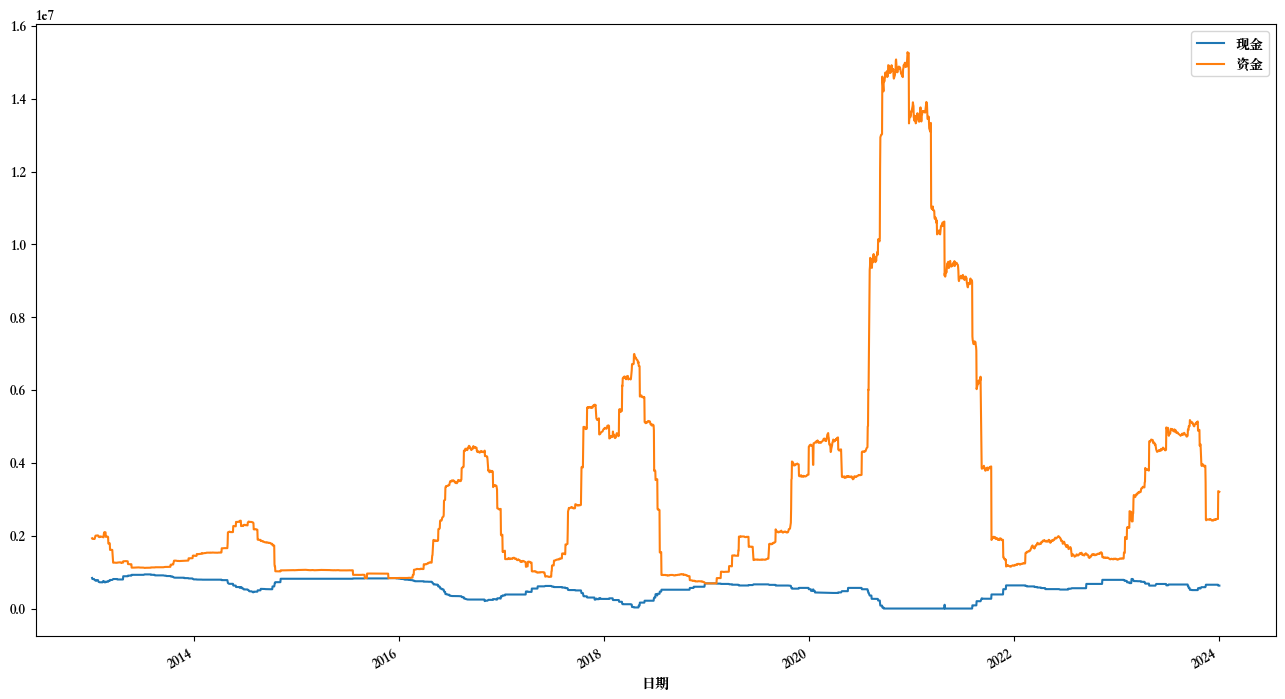

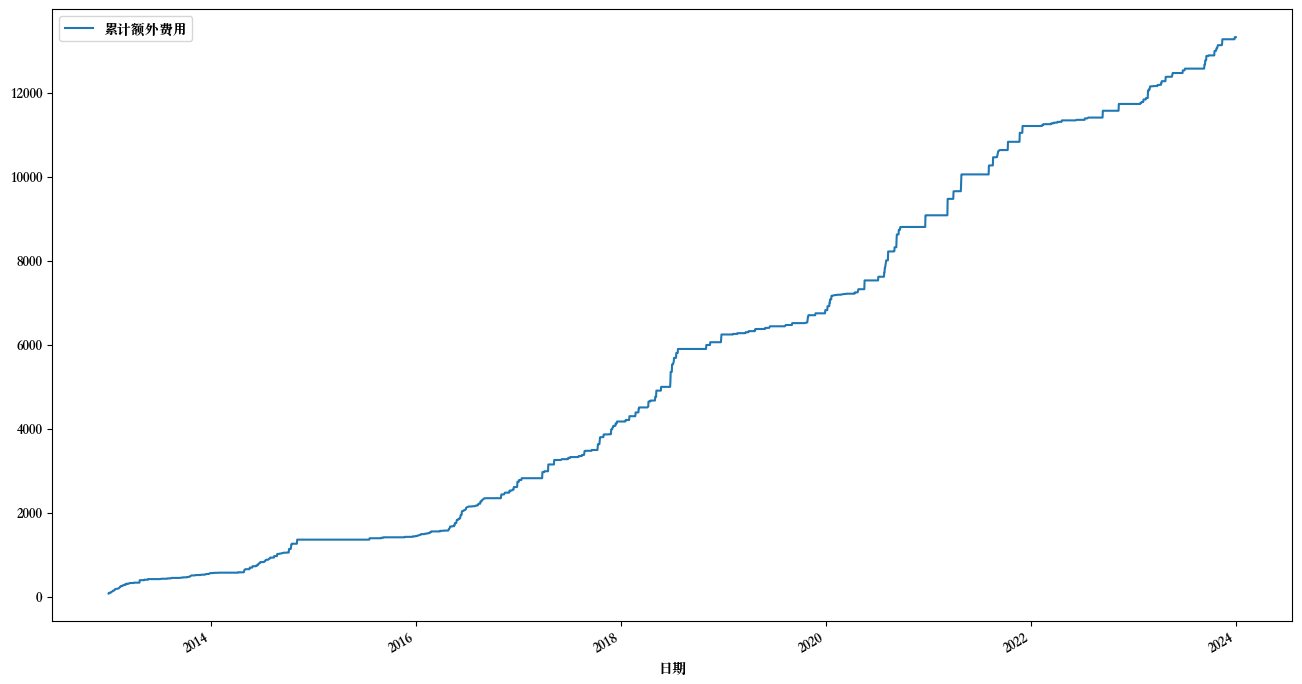

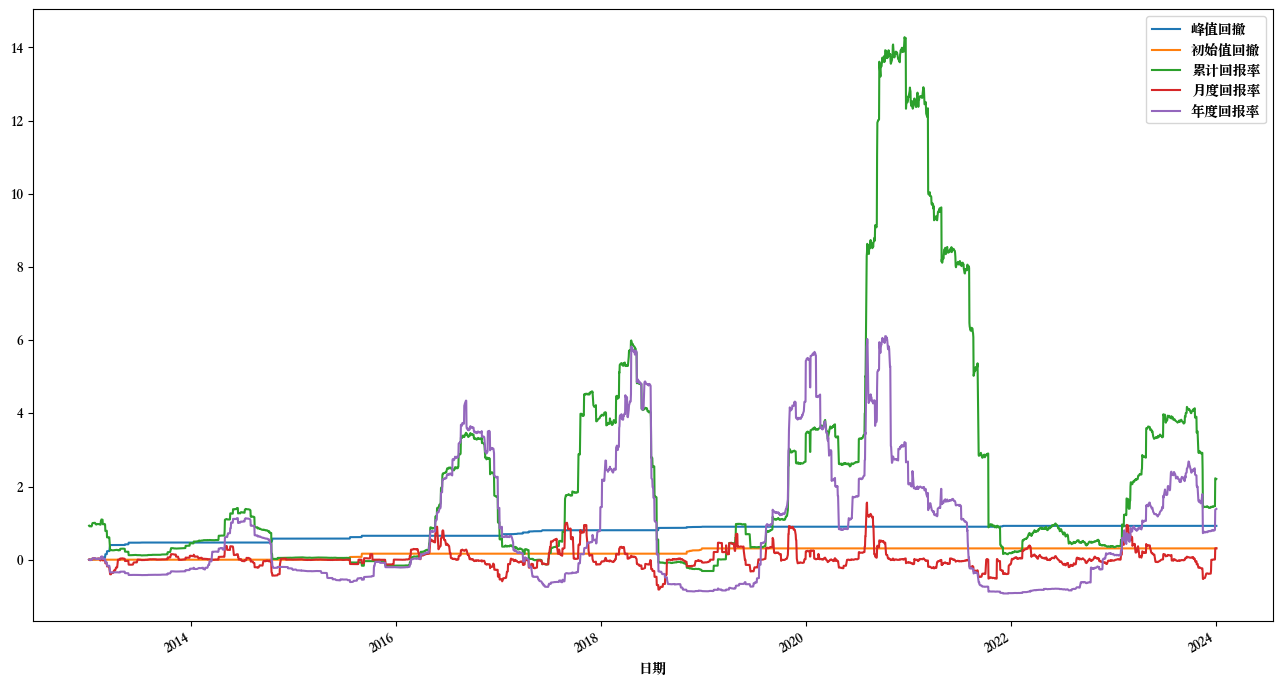

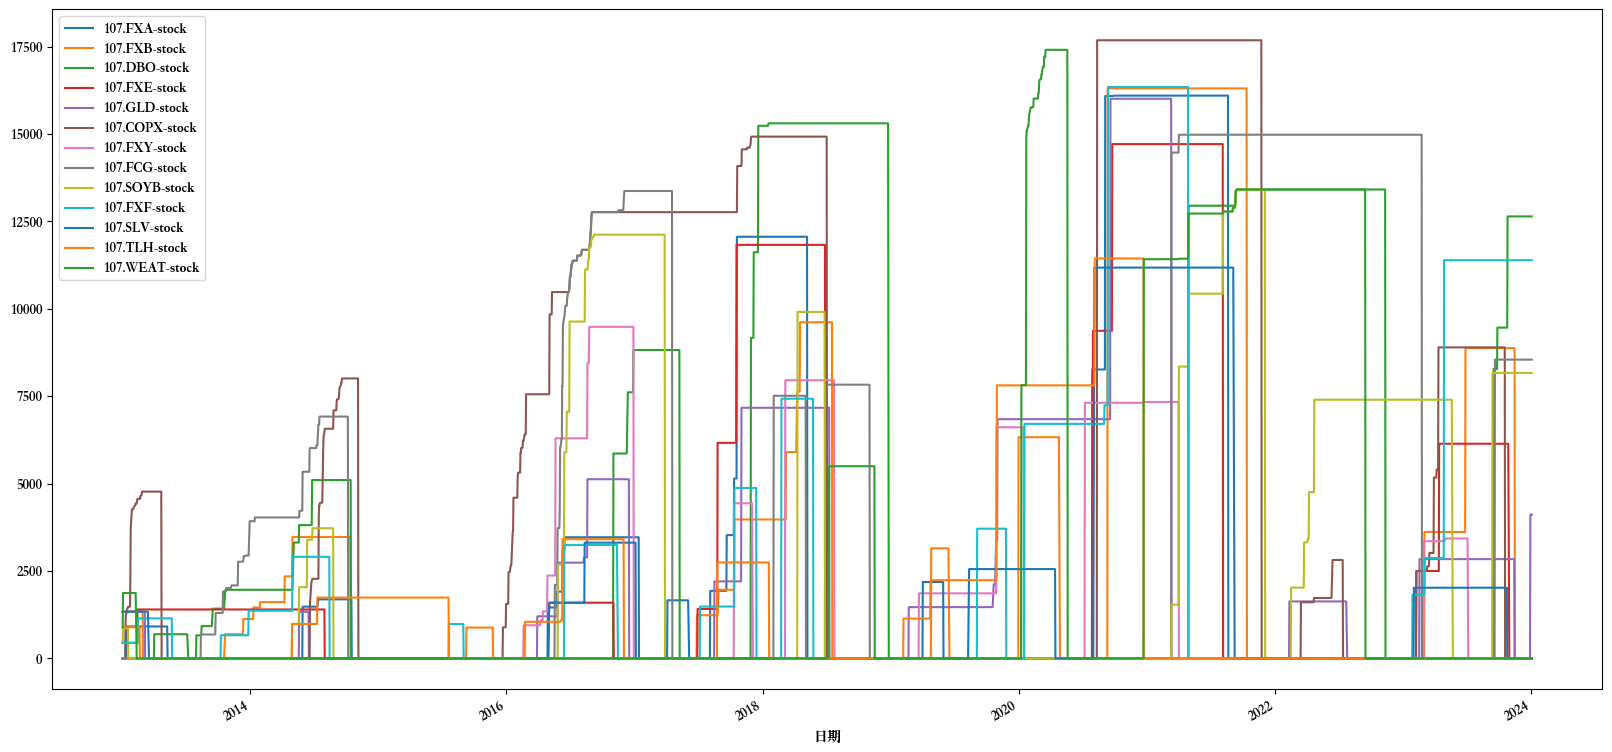

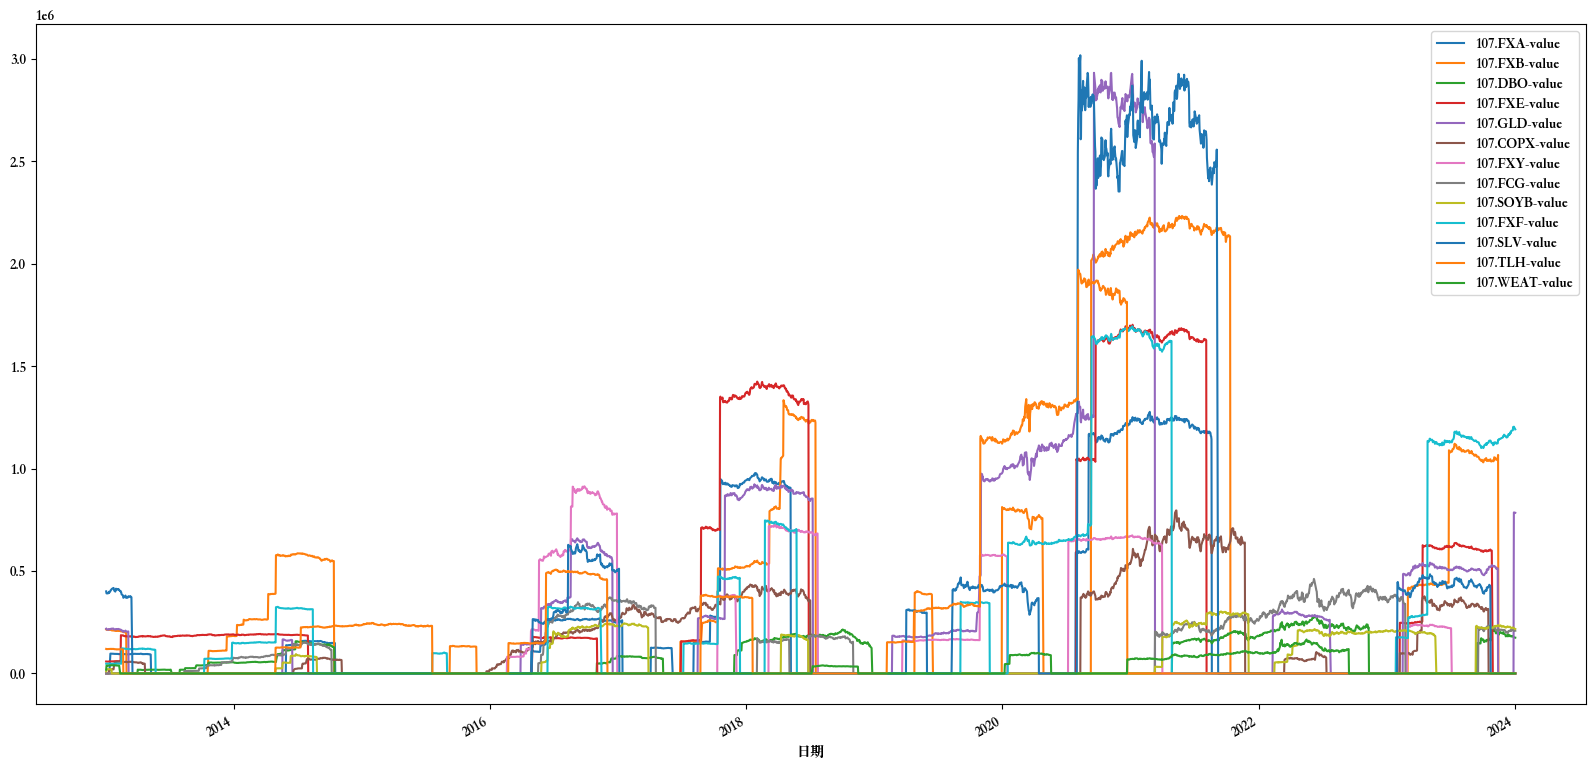

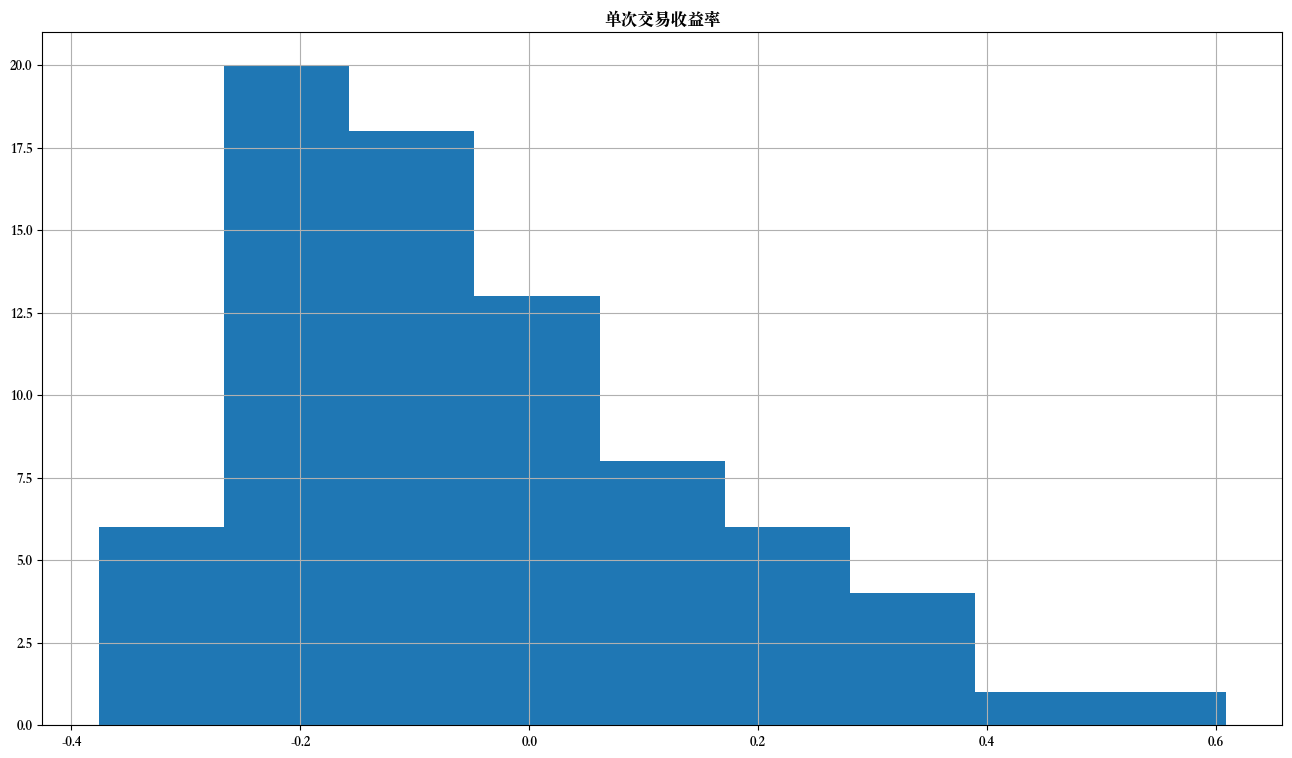

In [48]:
dma = DualMovingAverage().run()
comparison['双重移动平均线策略'] = dma

现金         445897.553583
资金        8560280.553583
累计额外费用      11073.588983
累计回报率           7.560281
Name: 2767, dtype: object


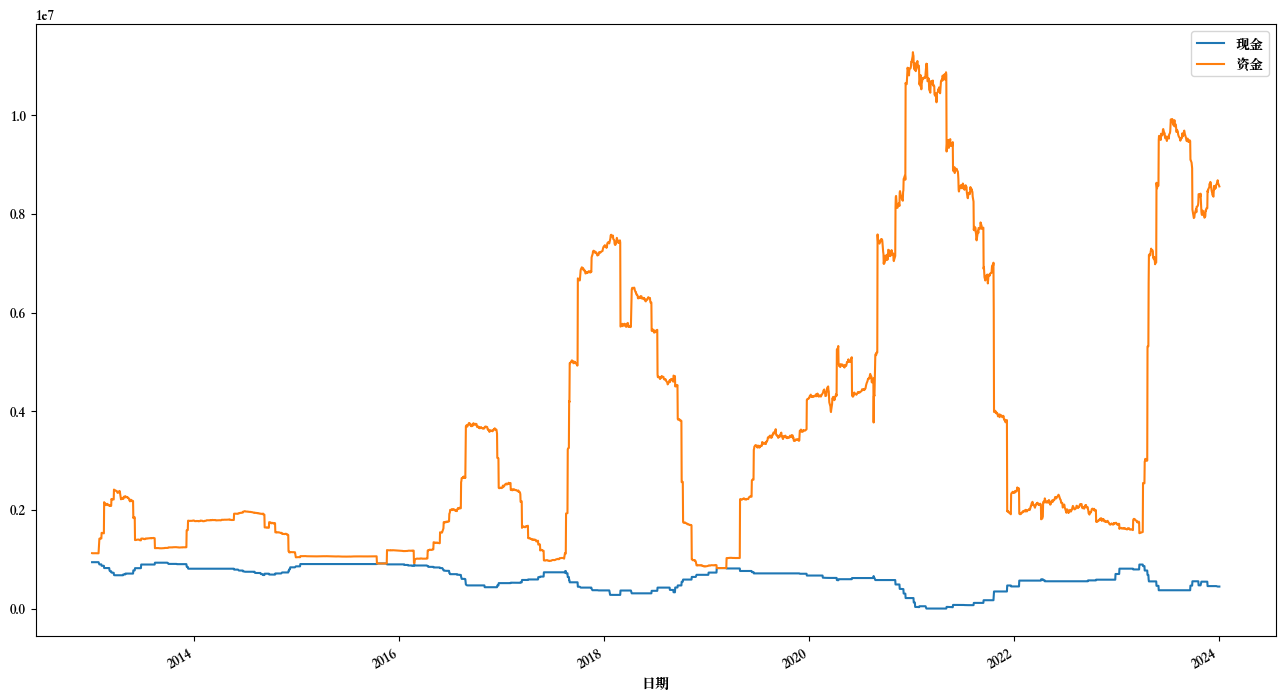

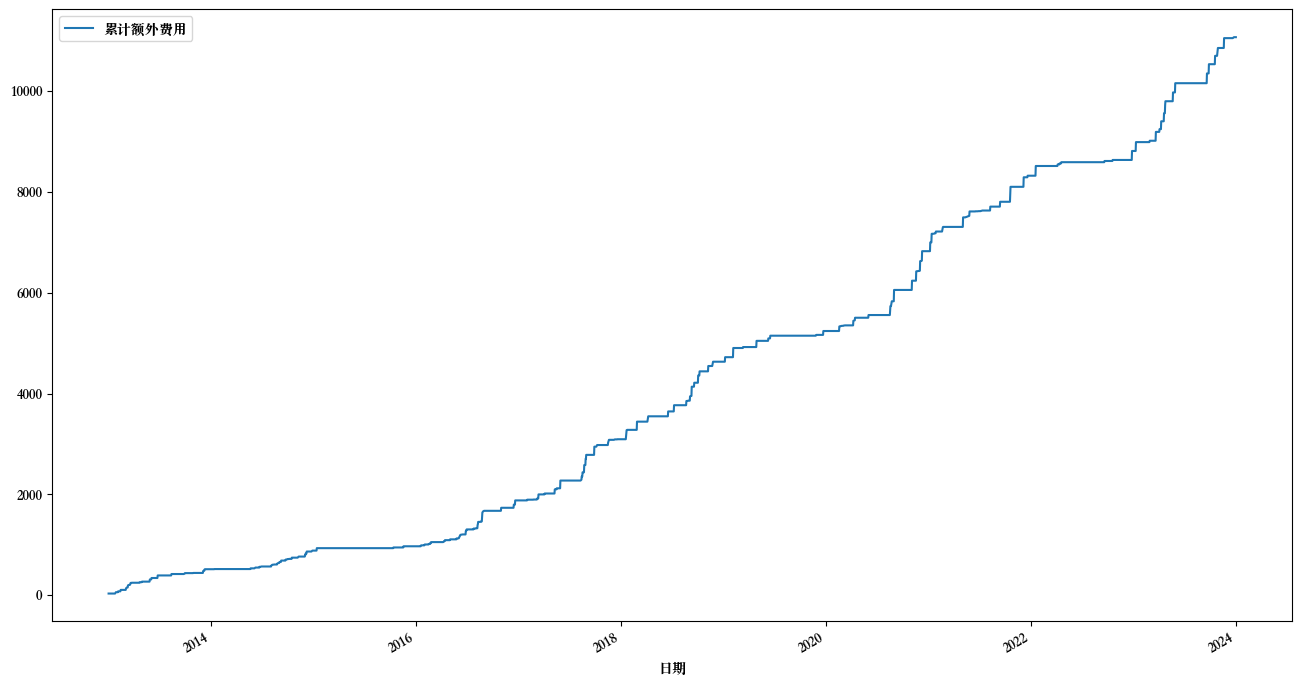

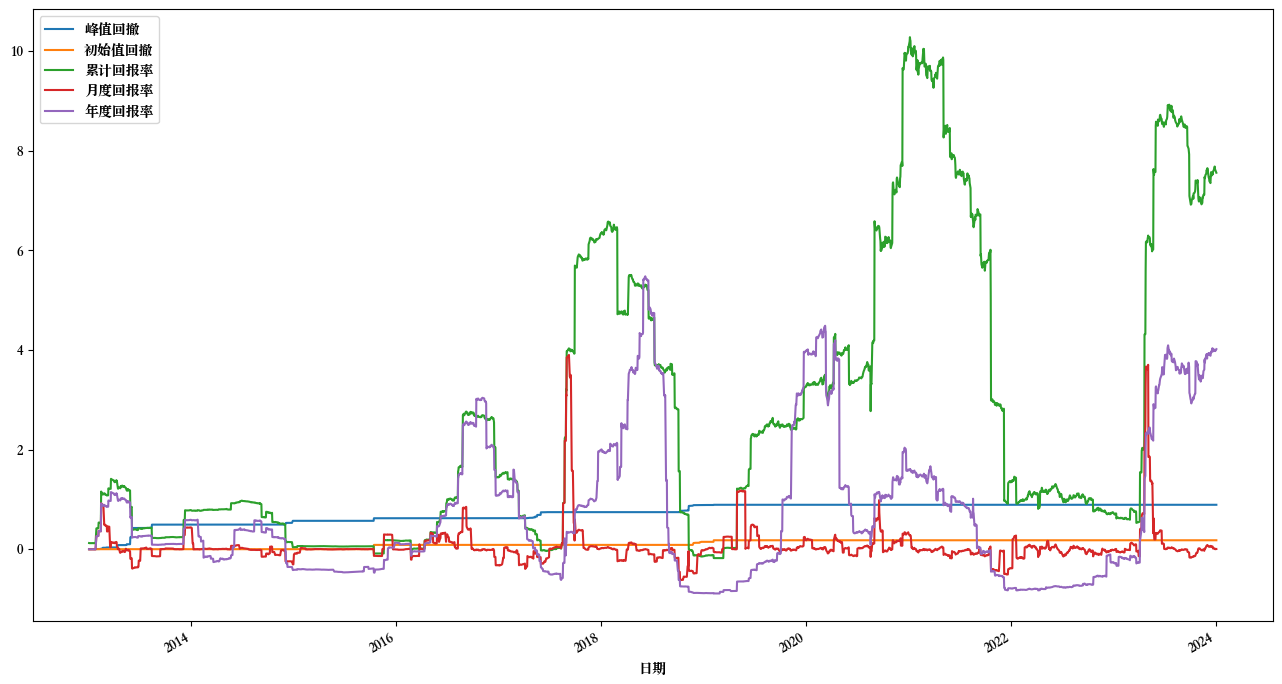

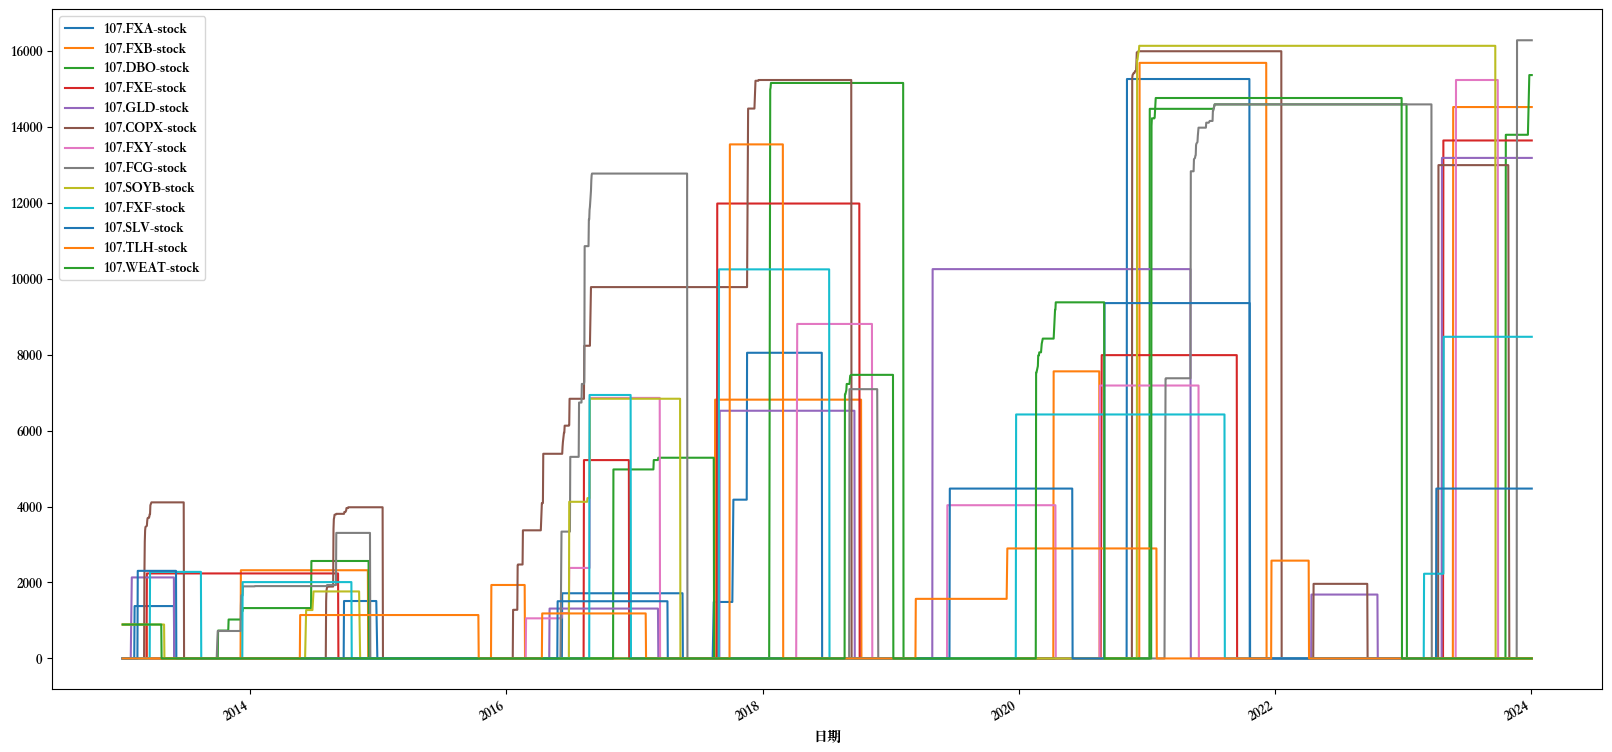

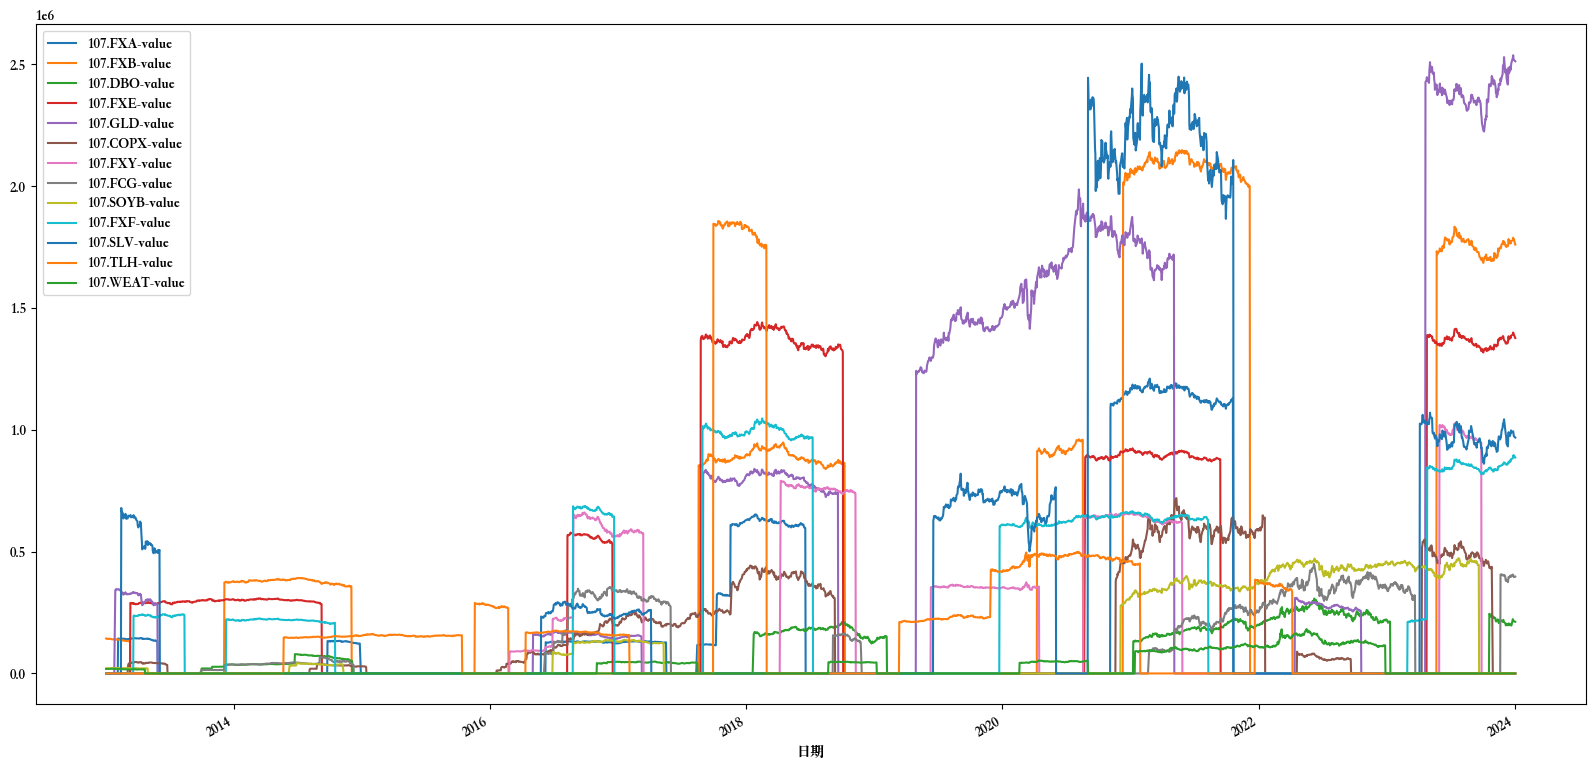

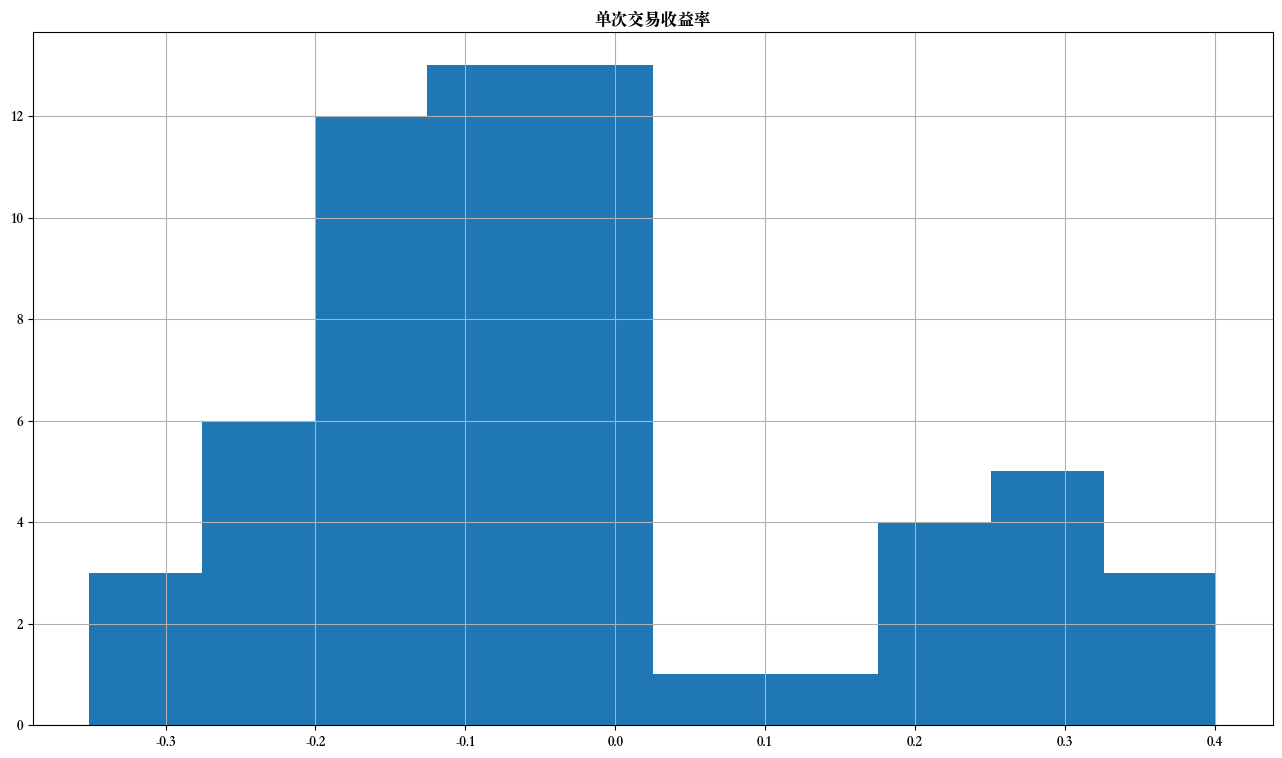

In [49]:
tma = TripleMovingAverage().run()
comparison['三重移动平均线策略'] = tma

### 系统表现对比

| System | CAGR% | MAR | Sharpe | Trades | W%  | Max DD | DD Length |
| :----: | :---: | :-: | :----: | :----: | :-: | :----: | :-------: |


In [50]:
df = pd.DataFrame.from_dict({name: detail.to_dict()
                            for name, detail in comparison.items()})
df

ATR通道突破策略    布林通道突破策略     唐奇安趋势策略  定时退出唐奇安趋势策略  \
CAGR%                          11.754242    5.467658    4.932690    17.052595   
MAR                             0.491228    0.225663    0.183215     0.181021   
Sharpe                          0.134516    0.118140    0.100157     0.051412   
Trades                         14.000000   25.000000  130.000000   305.000000   
W%                             28.571429   12.000000   34.615385    38.688525   
Max DD                          0.239283    0.242293    0.269229     0.942023   
DD Length                    1058.000000  841.000000  893.000000   710.000000   
Max DD (Since Beginning)        0.001616    0.000000    0.000000     0.477116   
DD Length (Since Beginning)    50.000000    0.000000    0.000000   181.000000   

                              双重移动平均线策略    三重移动平均线策略  
CAGR%                          4.724837    20.276213  
MAR                            0.051087     0.227387  
Sharpe                         0.014737     0.070878  
Trades                        77.000000    61.000000  
W%                            32.467532    27.868852  
Max DD                         0.924862     0.891705  
DD Length                    838.000000  1237.000000  
Max DD (Since Beginning)       0.308897     0.179118  
DD Length (Since Beginning)  149.000000    82.000000